In [123]:
%matplotlib inline

In [160]:
import os
import sys
import pandas
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn.mixture import GaussianMixture
from nilearn import plotting
sys.path.insert(0,'/Users/jakevogel/git/data_driven_pathology/esm/')
import ESM_utils as esm

In [17]:
bf = pandas.read_csv('/Users/jakevogel/Science/tau/Lund_2save/VISIT_JUNE2018/bf_Brainnectome_vals.csv',
                    index_col=0)
bf = bf.dropna()
adni = pandas.read_csv('/Users/jakevogel/Science/tau/Lund_2save/VISIT_JUNE2018/adni_Brainnectome_vals.csv',
                      index_col=0)
allsubs = pandas.concat([bf, adni])

In [14]:
mods = {'1comp': GaussianMixture(n_components=1),
        '2comp': GaussianMixture(n_components=2)}

In [18]:
all_probs, all_report = esm.Convert_ROI_values_to_Probabilities(allsubs, models=mods)

3 ROIs showed unexpected fitting behavior. See report...


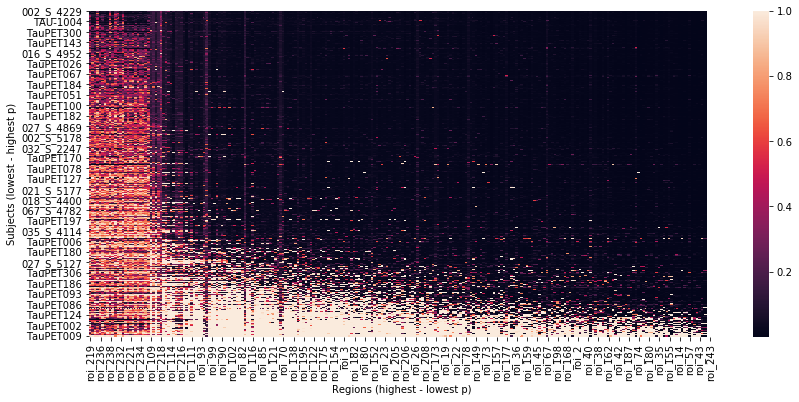

Index(['roi_219', 'roi_233', 'roi_240', 'roi_237', 'roi_236', 'roi_220',
       'roi_222', 'roi_239', 'roi_238', 'roi_235',
       ...
       'roi_57', 'roi_184', 'roi_178', 'roi_44', 'roi_43', 'roi_161', 'roi_58',
       'roi_242', 'roi_243', 'roi_244'],
      dtype='object', length=246)

In [19]:
esm.Plot_Probabilites(all_probs)

In [67]:
input_data = all_probs.dropna(1)
sub_cx = np.corrcoef(input_data)

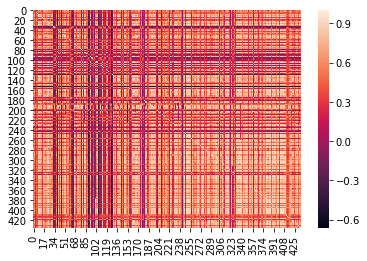

In [37]:
sns.heatmap(sub_cx)

In [40]:
sns.clustermap?

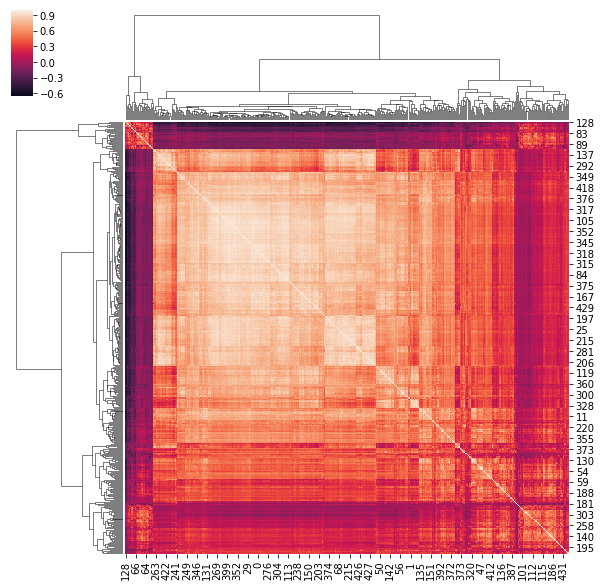

In [39]:
sns.clustermap(sub_cx)

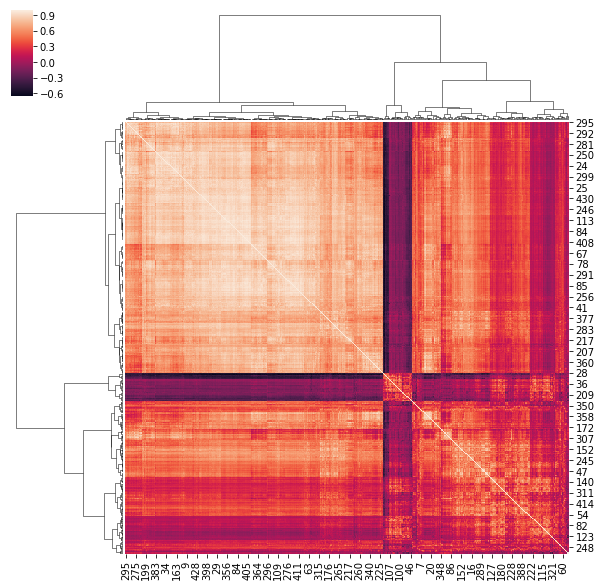

In [43]:
sns.clustermap(sub_cx, method='ward')

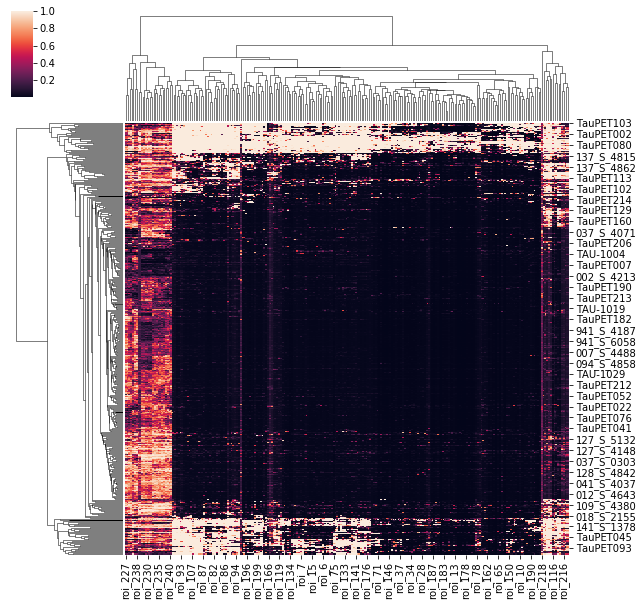

In [45]:
sns.clustermap(all_probs.dropna(1))

In [49]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

ks = range(2,20)
#X = g.data2d.values
X = np.array(sub_cx, copy=True)
cluster_solutions_1 = pandas.DataFrame(index = ks, columns = ['silhouette', 'CH_index',
                                                            'mean_size','min_size','max_size'])
connectivity = kneighbors_graph(X, n_neighbors=20, include_self=False)
for k in ks:
    clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
    cluster_labels = clusterer.fit_predict(X)
    # silhouette
    cluster_solutions_1.loc[k,'silhouette'] = silhouette_score(X, cluster_labels)
    # CH Index
    cluster_solutions_1.loc[k,'CH_index'] = calinski_harabaz_score(X, cluster_labels)
    mtx = pandas.DataFrame(X, copy=True)
    mtx.loc[:,'label'] = cluster_labels
    sizes = []
    for i in np.unique(mtx.label):
        clus_data = mtx[mtx.label==i][mtx.columns[:-1]]
        sizes.append(len(clus_data))
    # SIZES
    cluster_solutions_1.loc[k,'mean_size'] = np.mean(sizes)
    cluster_solutions_1.loc[k,'min_size'] = np.min(sizes)
    cluster_solutions_1.loc[k,'max_size'] = np.max(sizes)
   
    print('finished',k)

finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
finished 10
finished 11
finished 12
finished 13
finished 14
finished 15
finished 16
finished 17
finished 18
finished 19


In [51]:
cluster_solutions_1.loc[:,'k'] = range(2,20)

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


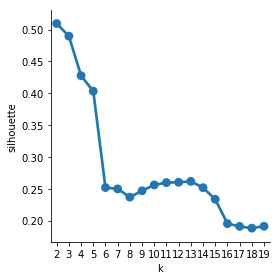

In [52]:
sns.factorplot(x='k', y='silhouette', data=cluster_solutions_1)

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


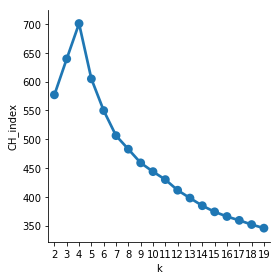

In [53]:
sns.factorplot(x='k', y='CH_index', data=cluster_solutions_1)

In [ ]:
k = 
connectivity = kneighbors_graph(X, n_neighbors=20, include_self=False)
clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)

#### Other methods for clustering
* Stability (cluster half sample, predict other half, then cluster other half and compare to predicted
* Community detection?
* Silhouette?


In [55]:
k = 13
clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
cluster_labels = clusterer.fit_predict(X)

In [93]:
atl_pth = '/Users/jakevogel/Science/Brainnectome/BN_Atlas_246_1mm.nii'

In [114]:
rois = [int(x.split('_')[-1]) for x in input_data.columns]
#rois

In [164]:
connectivity?

In [222]:
# VISUALIZE
def visualize_clusters(matrix, roi_labels, clust_labels, atlas_pth, 
                       illustrative=False, thresh = None):
    
    if matrix.shape[0] != len(clust_labels):
        matrix = matrix.T
    if type(matrix) == np.ndarray:
        matrix = pandas.DataFrame(matrix)
    else:
        matrix = pandas.DataFrame(matrix, copy=True)
    matrix.columns = roi_labels
    matrix.loc[:,'label'] = clust_labels
    
    atl_img = ni.load(atlas_pth)
    aff = atl_img.affine
    atl = atl_img.get_data()
    u = np.unique(atl)[1:]
    
    clust_imgs = {}
    for label in np.unique(clust_labels):
        print('working on cluster',label)
        clust_vals = matrix[matrix.label==label].mean()
        clust_dat = np.zeros_like(atl).astype(np.float32)
        for i in u:
            if i in roi_labels:
                clust_dat[atl==i] = clust_vals.loc[i]
        clust_img = ni.Nifti1Image(clust_dat, aff)
        clust_imgs.update({label: clust_img})
        if illustrative:
            n = len(matrix[matrix.label==label])
            print('cluster size = ',n)
            if len(clust_dat[clust_dat>thresh]) == 0:
                print('no rois above specified threshold. loosening threshold')
                nthresh = thresh / 0.5
                if len(clust_dat[clust_dat>nthresh]) == 0:
                    print('no rois above loosened threshold. no threshold applied')
                    nthresh = None
                plotting.plot_stat_map(clust_img, threshold = nthresh, draw_cross=False)
            else:
                plotting.plot_stat_map(clust_img, threshold = thresh, draw_cross=False)
            plt.show()
            
    return clust_imgs

working on cluster 0
cluster size =  24


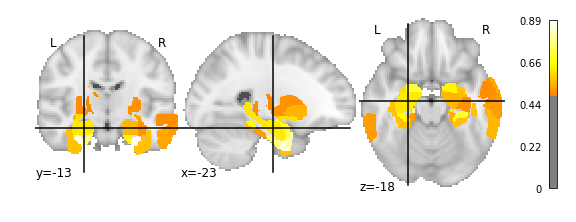

working on cluster 1
cluster size =  25


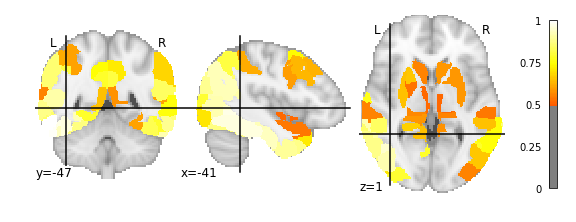

working on cluster 2
cluster size =  12


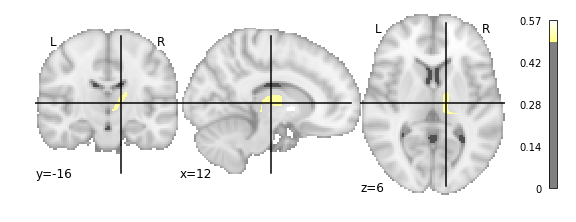

working on cluster 3
cluster size =  41


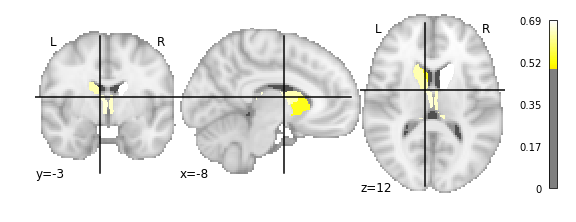

working on cluster 4
cluster size =  11


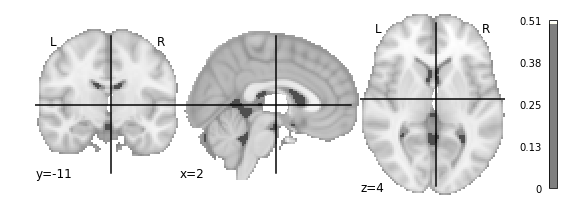

working on cluster 5
cluster size =  68


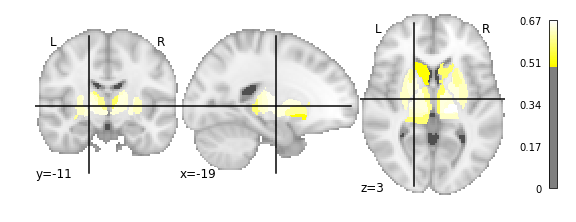

working on cluster 6
cluster size =  6


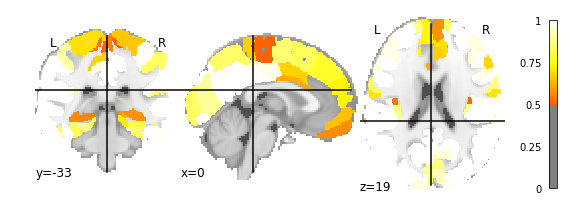

working on cluster 7
cluster size =  9


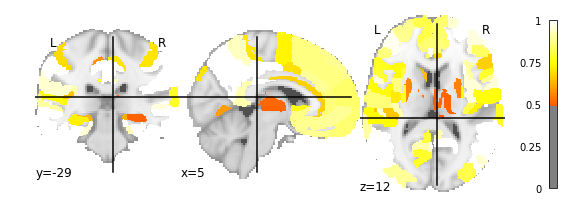

working on cluster 8
cluster size =  37


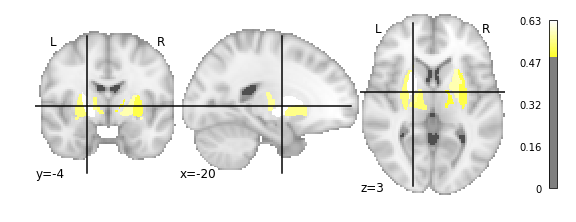

working on cluster 9
cluster size =  16


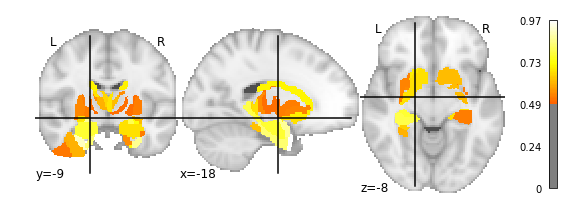

working on cluster 10
cluster size =  17


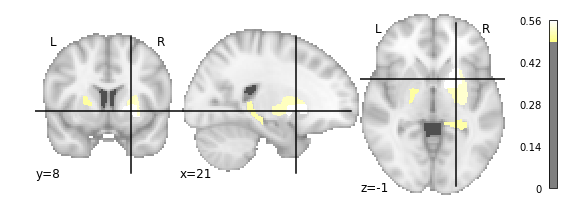

working on cluster 11
cluster size =  4


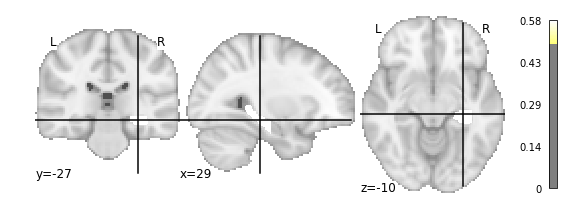

working on cluster 12
cluster size =  25


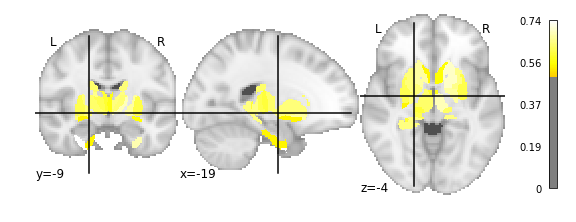

working on cluster 13
cluster size =  15


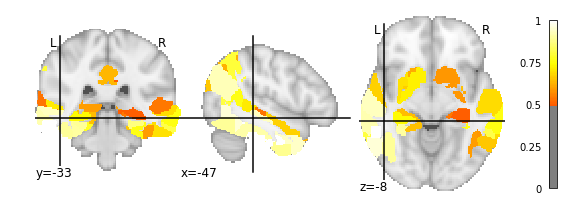

working on cluster 14
cluster size =  17


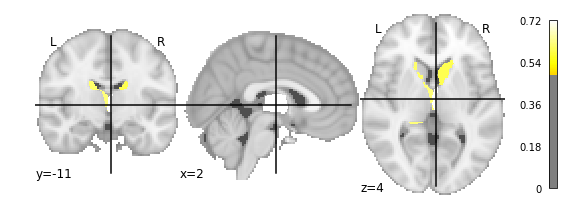

working on cluster 15
cluster size =  66


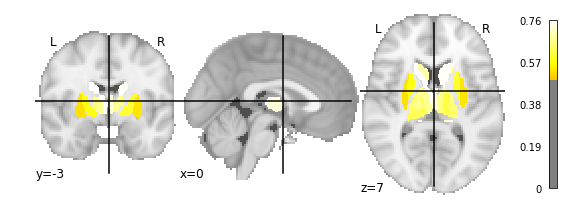

working on cluster 16
cluster size =  13


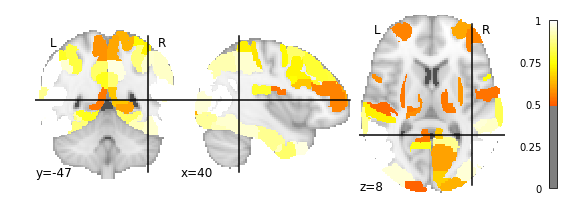

working on cluster 17
cluster size =  21


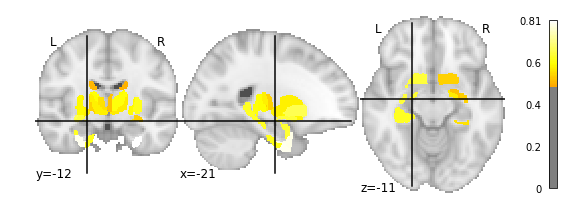

working on cluster 18
cluster size =  9


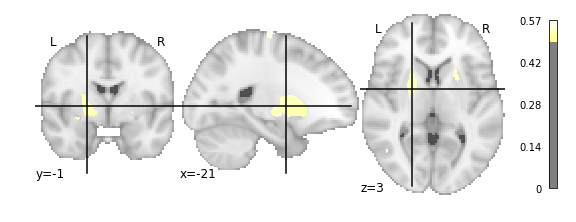

In [151]:
clust_imgs = visualize_clusters(input_data, rois, mtx.label.values, atl_pth, True, 0.5)

In [187]:
#output = poormans_basc(input_data, 3, 10, 1, True, None, True, 30)

In [185]:
calinski_harabaz_score(output['stability'],output['labels'])

2122.7200660720123

In [192]:
silhouette_score(output['stability'],output['labels'])

0.7963185757117955

running cluster analyses
working on iteration 0
working on iteration 1
working on iteration 2
working on iteration 3
working on iteration 4
working on iteration 5
working on iteration 6
working on iteration 7
working on iteration 8
working on iteration 9
creating stability matrix
working on iteration 0
working on iteration 1
working on iteration 2
working on iteration 3
working on iteration 4
working on iteration 5
working on iteration 6
working on iteration 7
working on iteration 8
working on iteration 9


//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


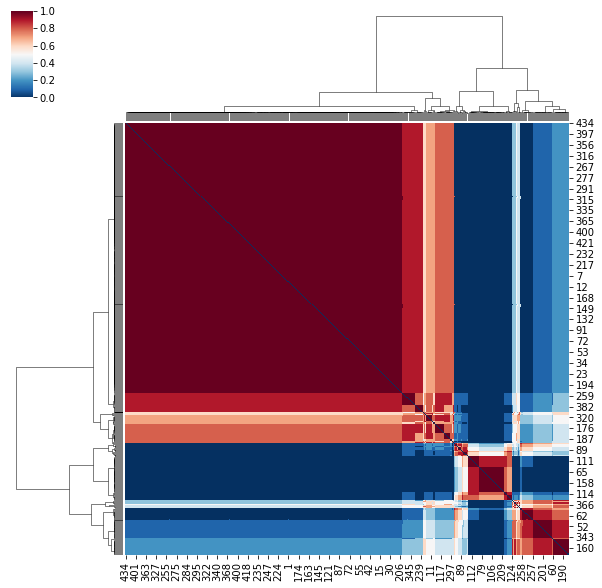

In [191]:
in_cx = pandas.DataFrame(sub_cx)
in_cx.index = input_data.index
in_cx.columns = input_data.index
output = poormans_basc(input_data, 3, 10, 1, True, None, True, 30)

In [181]:
def poormans_basc(in_mtx,n_clust,n_iter,checker,
                  bootstrap = False,
                  inner_cluster_object = None,
                  connect = False, neighbors = 20,
                  plotit = True):
    
    clust_mtx = pandas.DataFrame(index=in_mtx.index, copy=True)
    print('running cluster analyses')
    if type(inner_cluster_object) == type(None):
        inner_cluster_object = cluster.KMeans()
    for i in range(n_iter):
        tmp_mtx = pandas.DataFrame(in_mtx,copy=True)
        if i%checker == 0:
            print('working on iteration',i)
        if bootstrap:
            new_ind = np.random.choice(in_mtx.columns,len(in_mtx.columns))
            tmp_mtx = tmp_mtx[new_ind]
        if connect:
            connectivity = kneighbors_graph(tmp_mtx, n_neighbors=neighbors, 
                                            include_self=False)
            nlabs = cluster.AgglomerativeClustering(n_clust,connectivity=connectivity
                                              ).fit(tmp_mtx).labels_
            clust_mtx.loc[:,'i%s'%i] = nlabs
        else:
            clust_mtx.loc[:,'i%s'%i] = inner_cluster_object.fit(tmp_mtx).labels_
    print('creating stability matrix')
    id_mtx = np.zeros((len(clust_mtx),len(clust_mtx)))
    for i in range(n_iter):
        if i%checker == 0:
            print('working on iteration',i)
        icol = pandas.Series(clust_mtx.values[:,i])
        for u in np.unique(icol):
            id_mtx[[x[0] for x in itertools.combinations(icol[icol==u].index.tolist(),2)],[
                    y[1] for y in itertools.combinations(icol[icol==u].index.tolist(),2)]] += 1
    stab_mtx = id_mtx/n_iter
    
    stab_mtx[np.tril_indices_from(stab_mtx)] = stab_mtx.transpose()[
                                            np.tril_indices_from(stab_mtx)]
    
    if plotit:
        plt.close()
        sns.clustermap(stab_mtx, cmap = 'RdBu_r')
        plt.show()
    
    connectivity = kneighbors_graph(stab_mtx, n_neighbors=neighbors, include_self=False)
    aggclust = cluster.AgglomerativeClustering(n_clust,connectivity=connectivity
                                              ).fit(stab_mtx)
    
    newdf = pandas.DataFrame(in_mtx, copy=True)
    newdf.loc[:,'order'] = aggclust.labels_
    output = {'cluster_object': aggclust, 'stability': stab_mtx,
              'dataframe': newdf, 'labels': aggclust.labels_}
    
    return output

In [200]:
ks = range(2,21)
basc_results = pandas.DataFrame(index = ks, columns = ['k','silhouette', 'CH_index',
                                                        'mean_size','min_size','max_size'])
basc_results.loc[:,'k'] = ks
for k in ks:
    print('>>>>>>> k = %s <<<<<<<'%k)
    output = poormans_basc(input_data, k, 100, 100, True, None, True, 30, plotit=False)
    # scores
    basc_results.loc[k,'silhouette'] = calinski_harabaz_score(output['stability'],
                                                              output['labels'])
    basc_results.loc[k,'CH_index'] = silhouette_score(output['stability'],
                                                      output['labels'])
    # sizes
    sizes = [len(output['labels'][output['labels']==x]) for x in np.unique(output['labels'])]
    basc_results.loc[k,'mean_size'] = np.mean(sizes)
    basc_results.loc[k,'min_size'] = np.min(sizes)
    basc_results.loc[k,'max_size'] = np.max(sizes)

>>>>>>> k = 2 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 3 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 4 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 5 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 6 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 7 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 8 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 9 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 10 <<<<<<<
running cluster analyses


In [195]:
len(output['labels']==0)

436

In [196]:
output['labels'][output['labels']==0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


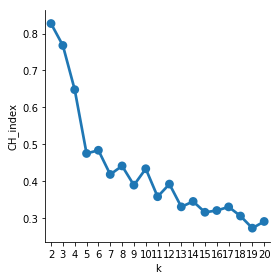

In [202]:
sns.factorplot(x='k', y='CH_index', data=basc_results)

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


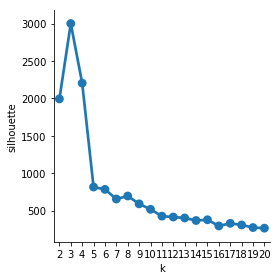

In [203]:
sns.factorplot(x='k', y='silhouette', data=basc_results)

>>>>>>>> K = 2 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  69


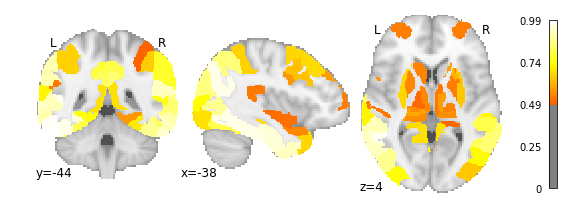

working on cluster 1
cluster size =  367


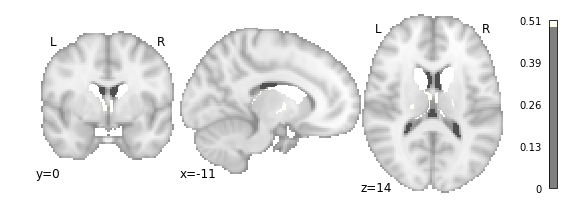

>>>>>>>> K = 3 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  69


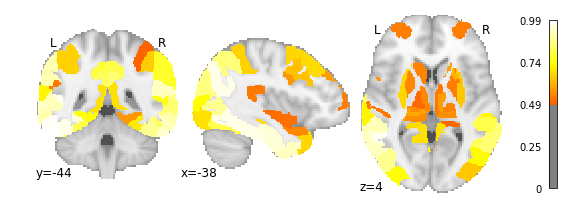

working on cluster 1
cluster size =  325


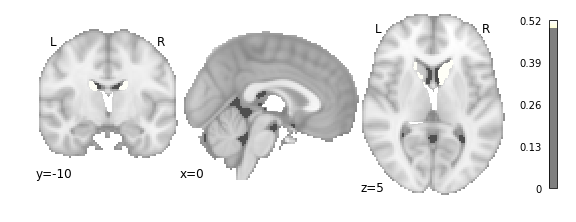

working on cluster 2
cluster size =  42


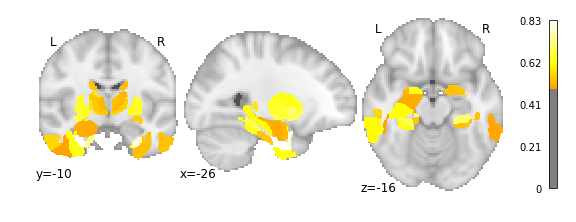

>>>>>>>> K = 4 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  65


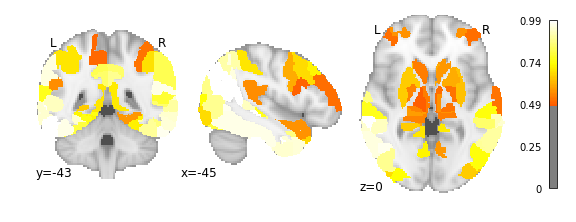

working on cluster 1
cluster size =  293


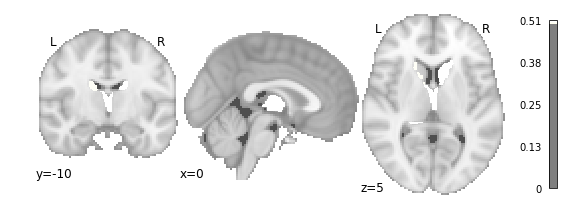

working on cluster 2
cluster size =  51


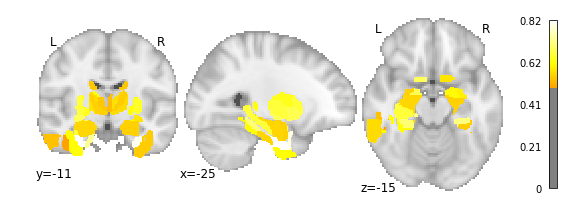

working on cluster 3
cluster size =  27


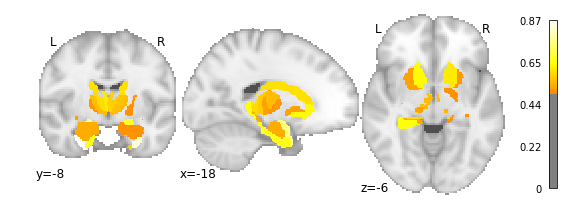

>>>>>>>> K = 5 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  138


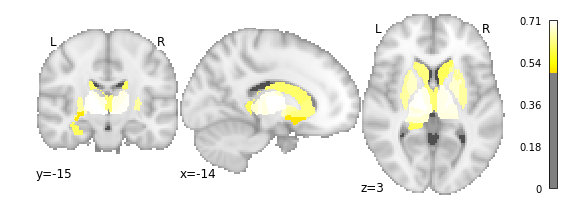

working on cluster 1
cluster size =  86


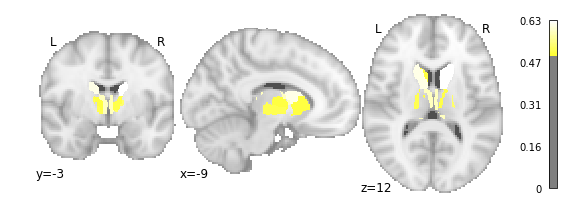

working on cluster 2
cluster size =  56


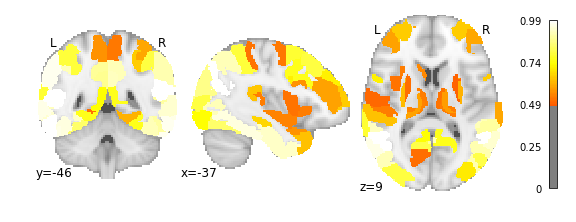

working on cluster 3
cluster size =  103


/Users/jakevogel/.local/lib/python3.5/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


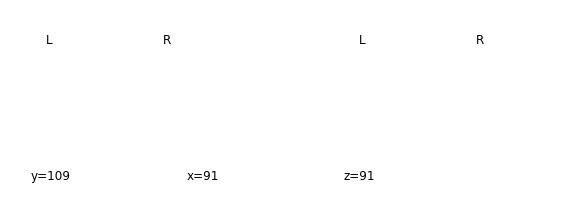

working on cluster 4
cluster size =  53


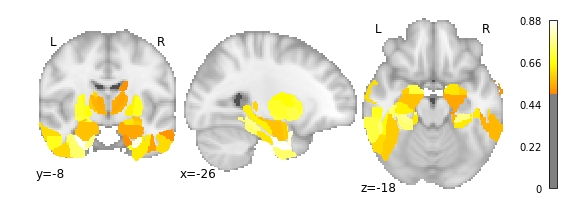

>>>>>>>> K = 6 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  119


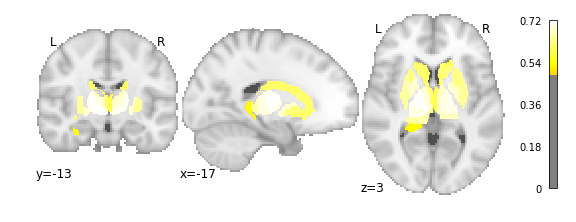

working on cluster 1
cluster size =  65


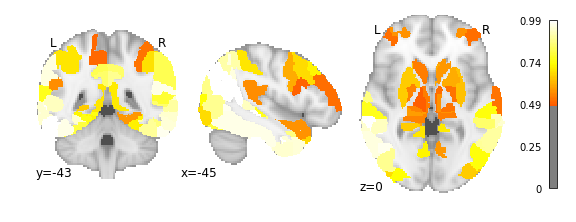

working on cluster 2
cluster size =  69


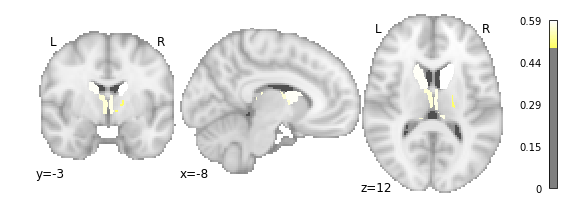

working on cluster 3
cluster size =  38


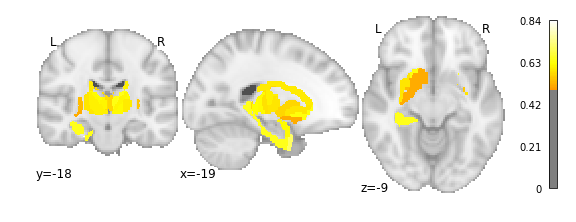

working on cluster 4
cluster size =  50


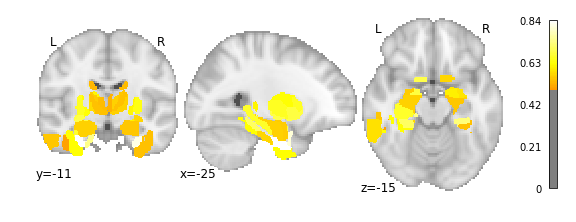

working on cluster 5
cluster size =  95


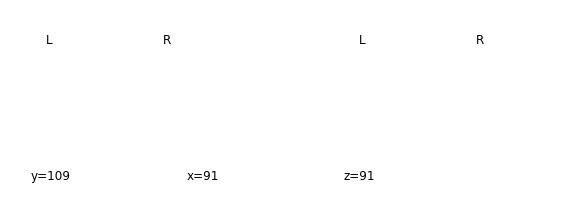

>>>>>>>> K = 8 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  119


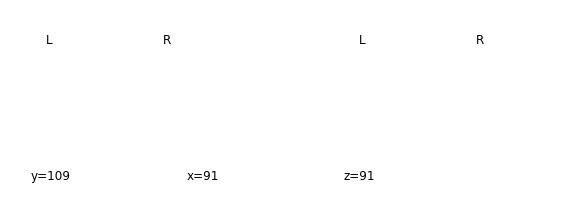

working on cluster 1
cluster size =  46


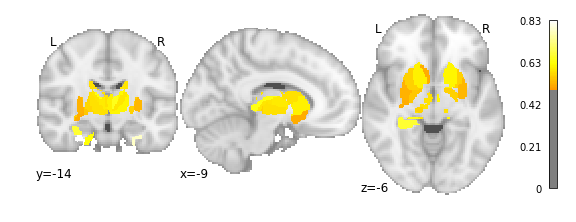

working on cluster 2
cluster size =  55


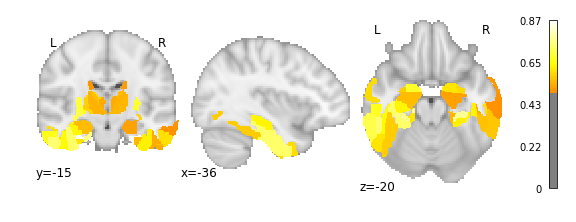

working on cluster 3
cluster size =  33


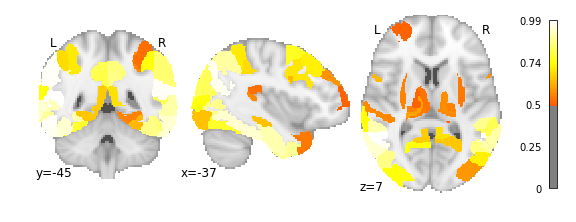

working on cluster 4
cluster size =  44


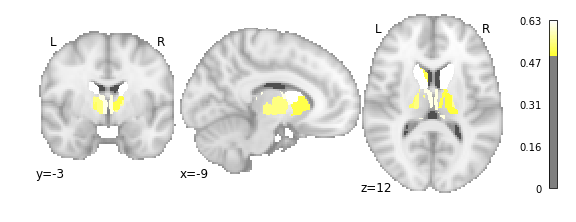

working on cluster 5
cluster size =  60


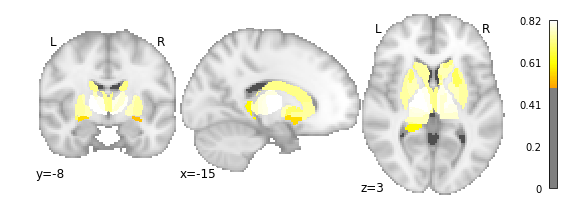

working on cluster 6
cluster size =  57


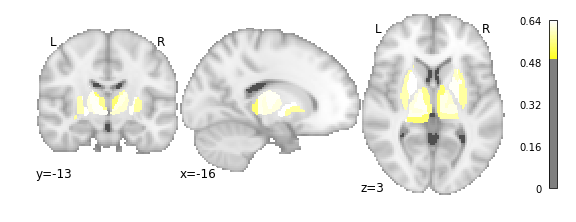

working on cluster 7
cluster size =  22


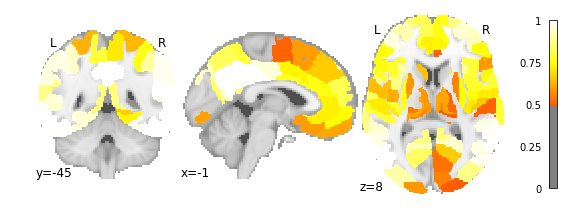

>>>>>>>> K = 10 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  42


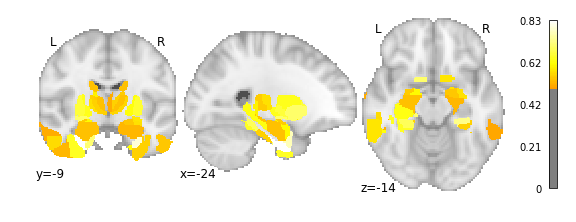

working on cluster 1
cluster size =  53


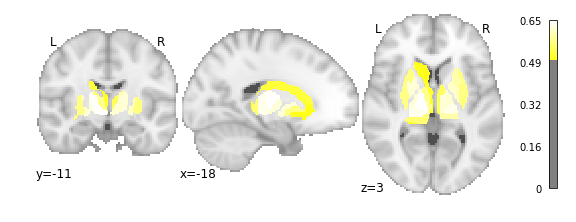

working on cluster 2
cluster size =  50


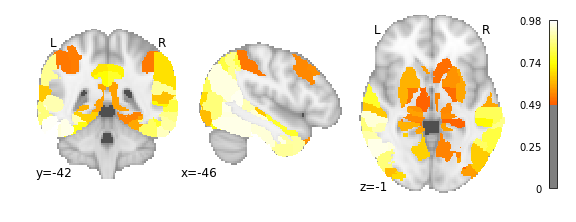

working on cluster 3
cluster size =  61


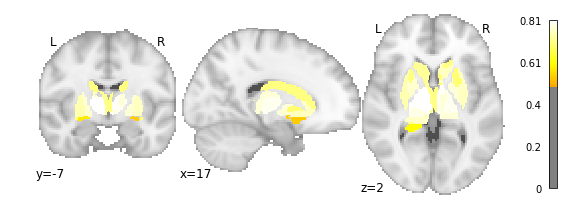

working on cluster 4
cluster size =  38


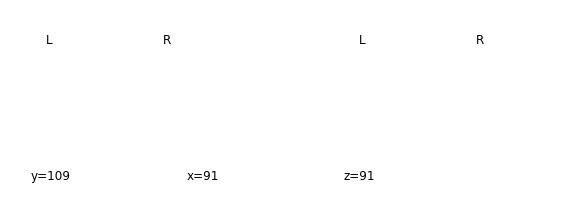

working on cluster 5
cluster size =  58


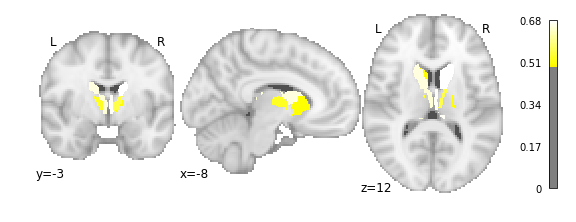

working on cluster 6
cluster size =  19


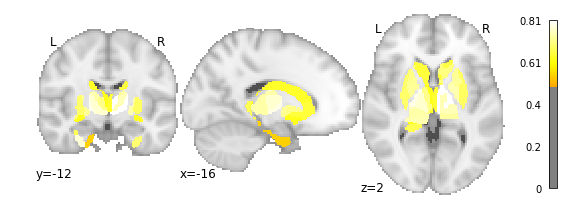

working on cluster 7
cluster size =  70


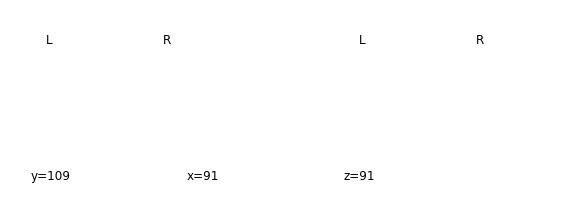

working on cluster 8
cluster size =  26


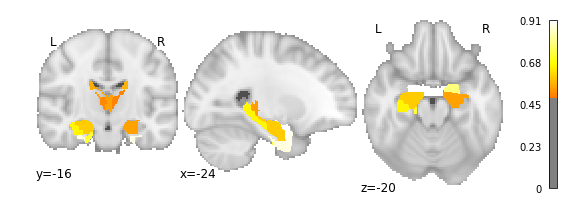

working on cluster 9
cluster size =  19


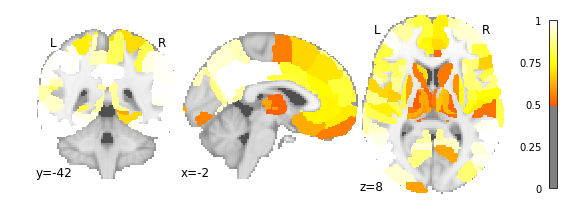

>>>>>>>> K = 12 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  55


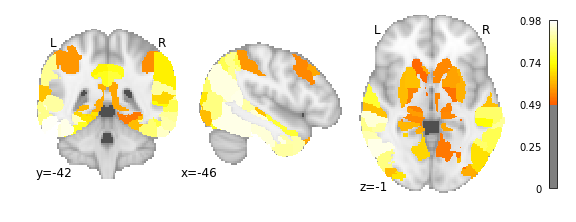

working on cluster 1
cluster size =  32


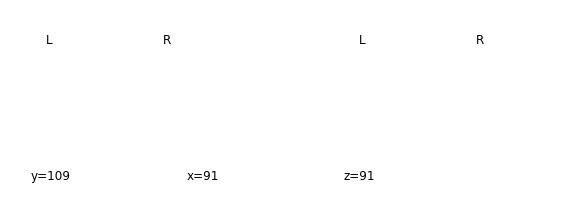

working on cluster 2
cluster size =  52


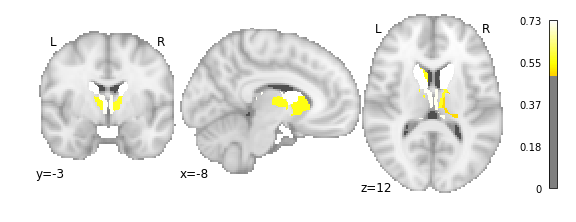

working on cluster 3
cluster size =  55


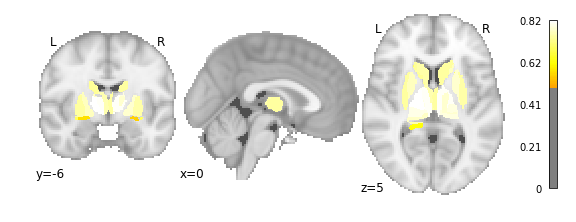

working on cluster 4
cluster size =  40


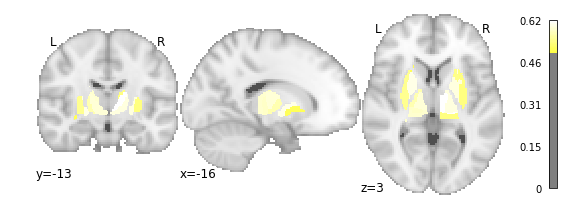

working on cluster 5
cluster size =  19


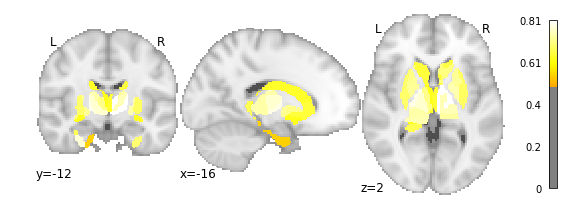

working on cluster 6
cluster size =  78


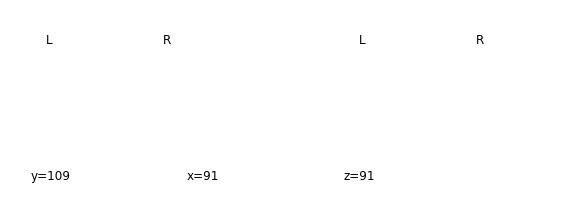

working on cluster 7
cluster size =  23


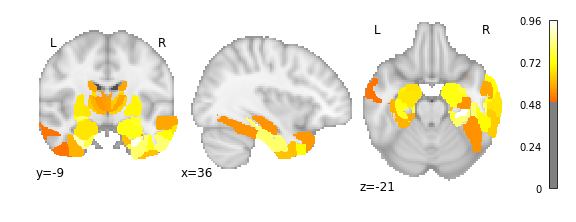

working on cluster 8
cluster size =  20


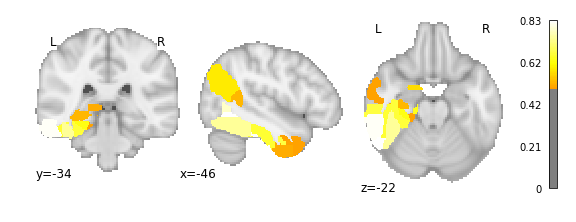

working on cluster 9
cluster size =  25


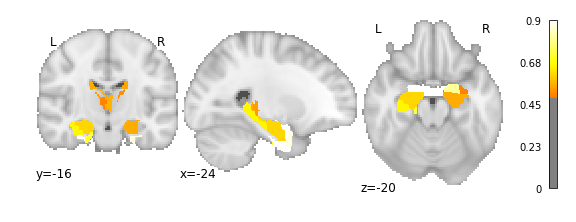

working on cluster 10
cluster size =  23


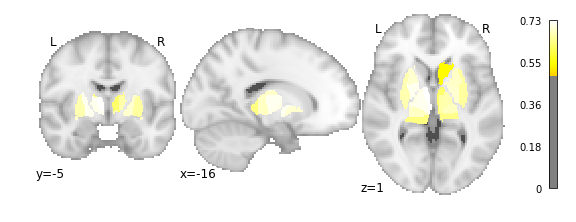

working on cluster 11
cluster size =  14


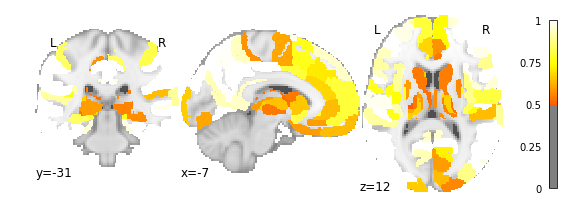

>>>>>>>> K = 14 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  17


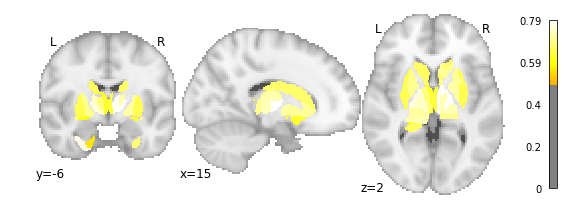

working on cluster 1
cluster size =  53


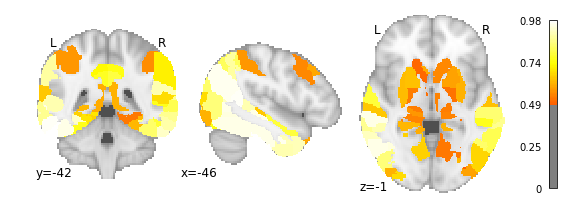

working on cluster 2
cluster size =  34


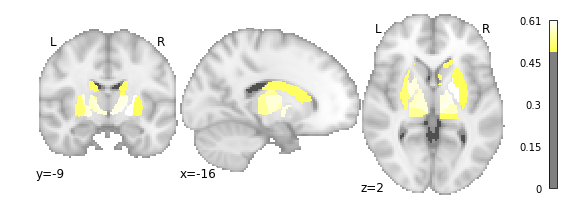

working on cluster 3
cluster size =  28


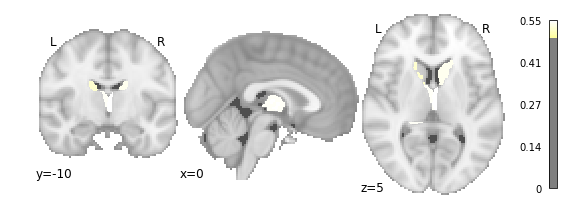

working on cluster 4
cluster size =  43


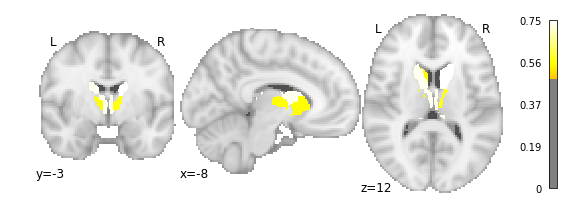

working on cluster 5
cluster size =  20


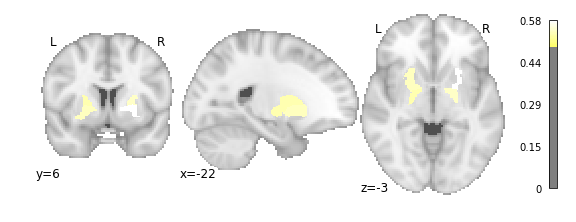

working on cluster 6
cluster size =  62


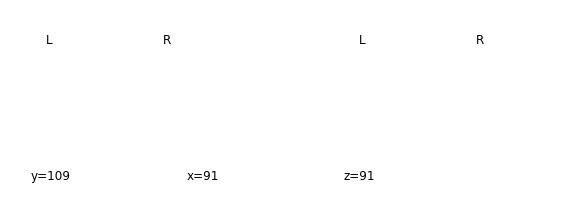

working on cluster 7
cluster size =  22


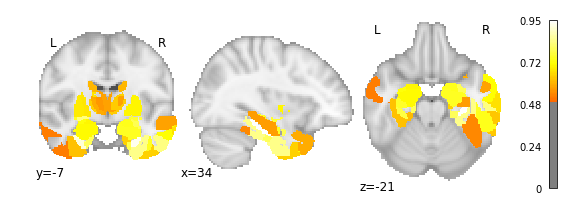

working on cluster 8
cluster size =  34


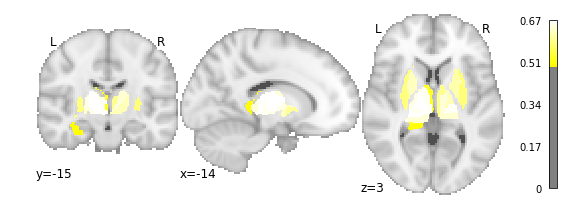

working on cluster 9
cluster size =  25


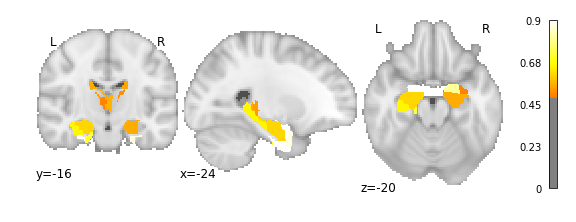

working on cluster 10
cluster size =  22


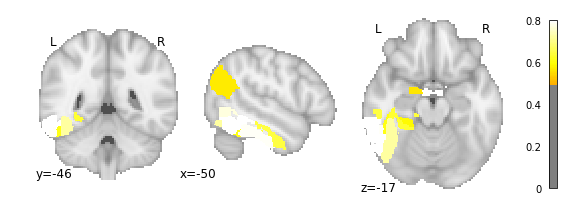

working on cluster 11
cluster size =  34


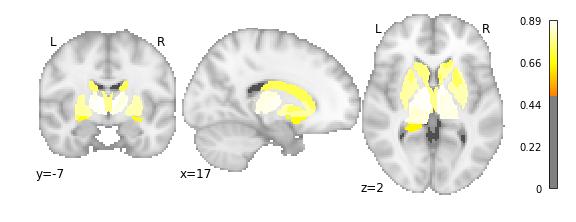

working on cluster 12
cluster size =  15


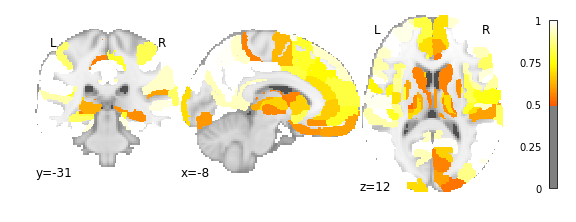

working on cluster 13
cluster size =  27


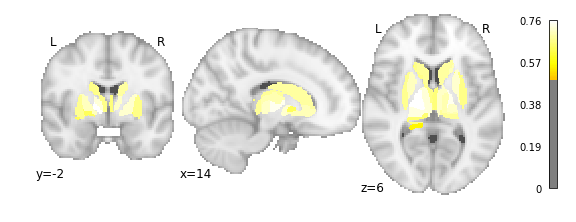

In [204]:
for k in [2, 3, 4]:
    print('>>>>>>>> K = %s <<<<<<<<'%k)
    output = poormans_basc(input_data, k, 100, 100, True, None, True, 30, plotit=False)
    clust_imgs = visualize_clusters(input_data, rois, output['labels'], atl_pth, True, 0.5)

In [238]:
good_fits = [x for x in range(len(jnk)) if jnk[x]>0]

In [242]:
newlabs = output['labels'][good_fits]

>>>>>>>> K = 2 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  64


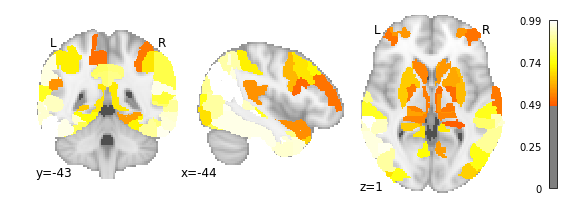

working on cluster 1
cluster size =  366


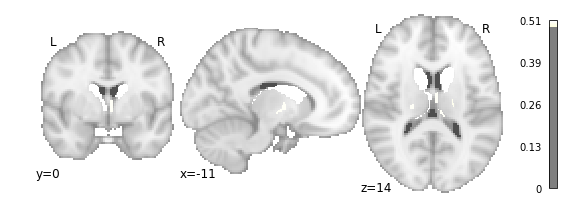

>>>>>>>> K = 3 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  57


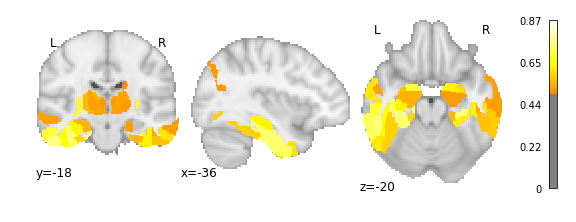

working on cluster 1
cluster size =  320


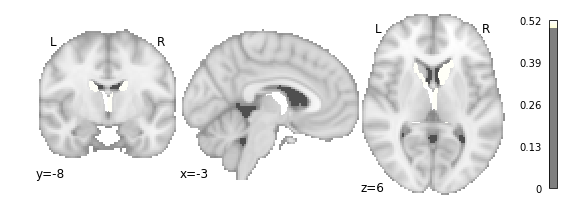

working on cluster 2
cluster size =  46


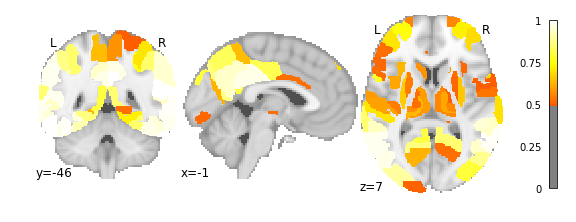

>>>>>>>> K = 4 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  55


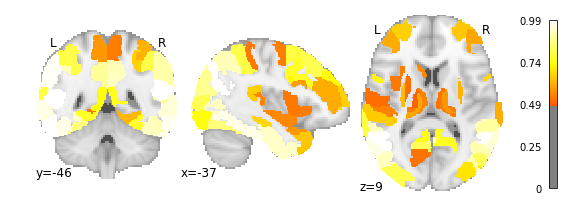

working on cluster 1
cluster size =  290


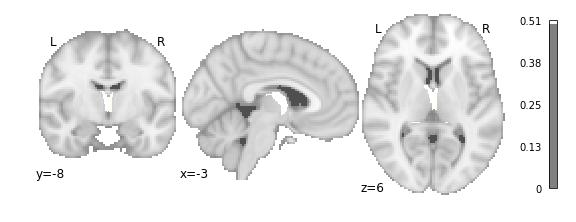

working on cluster 2
cluster size =  52


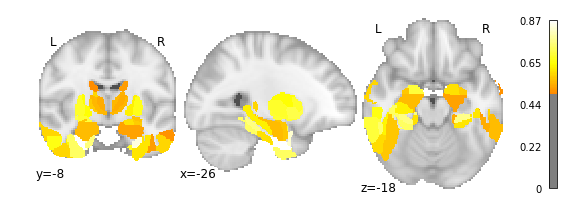

working on cluster 3
cluster size =  32


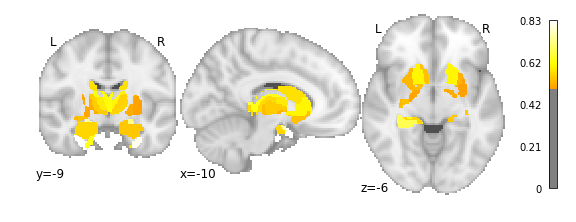

In [244]:
for k in [2, 3, 4]:
    print('>>>>>>>> K = %s <<<<<<<<'%k)
    output = poormans_basc(input_data, k, 100, 100, True, None, True, 30, plotit=False)
    jnk = silhouette_samples(output['stability'],output['labels'])
    good_fits = [x for x in range(len(jnk)) if jnk[x]>0]
    tmp_mtx = input_data.loc[input_data.index[good_fits]]
    newlabs = output['labels'][good_fits]
    clust_imgs = visualize_clusters(tmp_mtx, rois, newlabs, atl_pth, True, 0.5)

>>>>>>>> K = 5 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  132


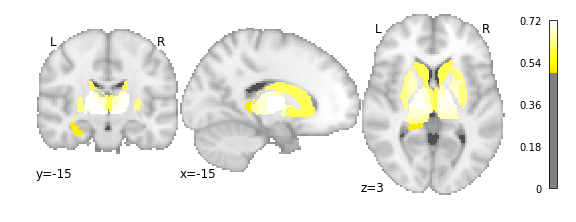

working on cluster 1
cluster size =  49


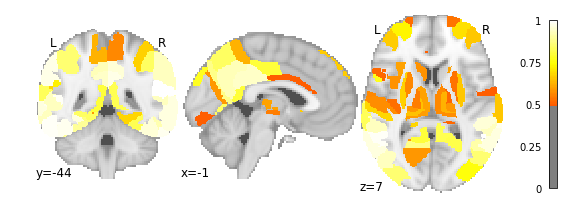

working on cluster 2
cluster size =  152
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


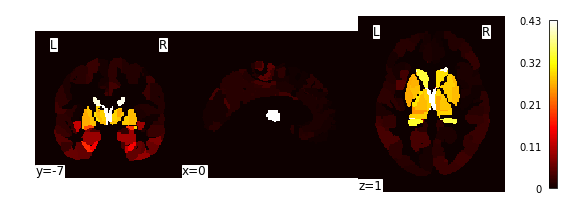

working on cluster 3
cluster size =  43


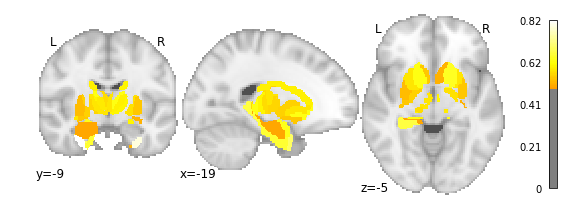

working on cluster 4
cluster size =  60


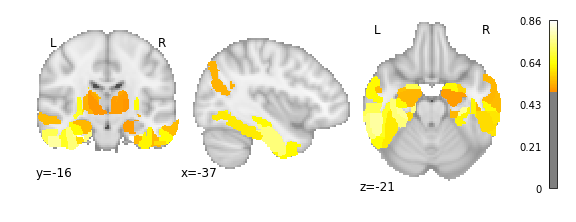

>>>>>>>> K = 6 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  99


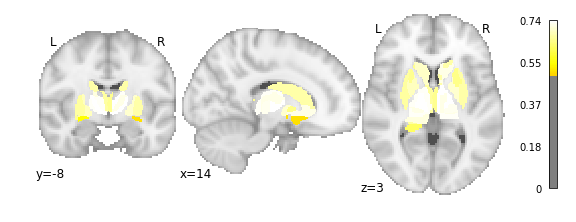

working on cluster 1
cluster size =  55


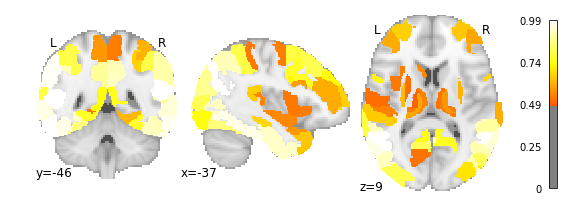

working on cluster 2
cluster size =  118
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


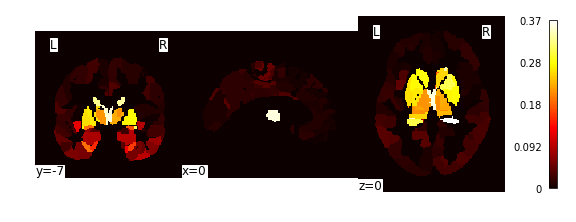

working on cluster 3
cluster size =  53


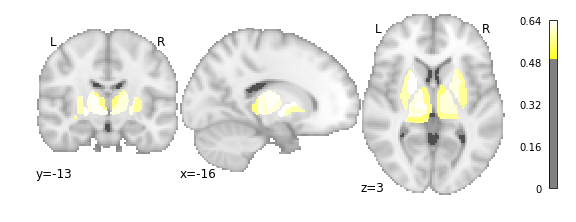

working on cluster 4
cluster size =  60


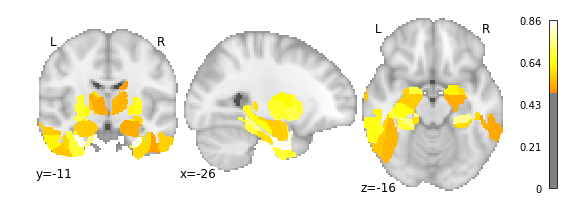

working on cluster 5
cluster size =  51


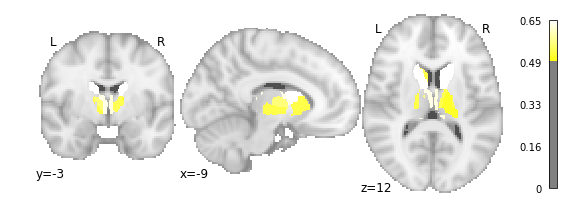

>>>>>>>> K = 8 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  120
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


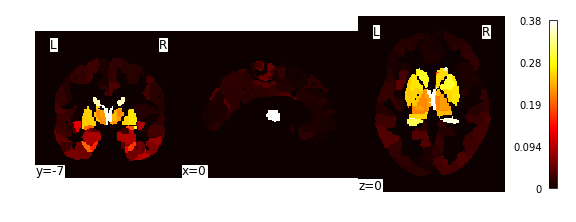

working on cluster 1
cluster size =  48


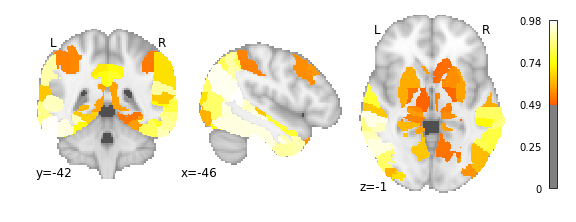

working on cluster 2
cluster size =  55


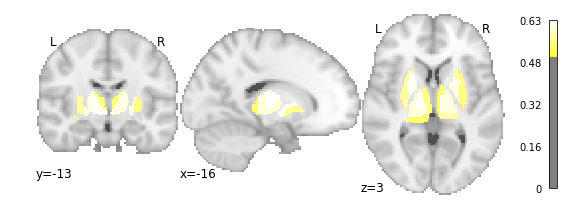

working on cluster 3
cluster size =  37


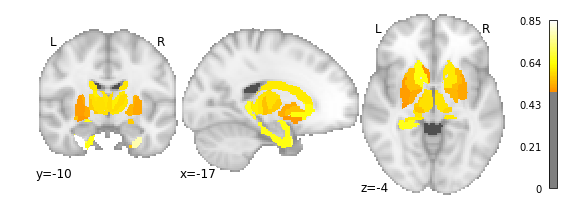

working on cluster 4
cluster size =  68


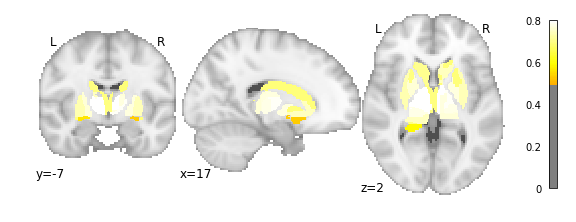

working on cluster 5
cluster size =  41


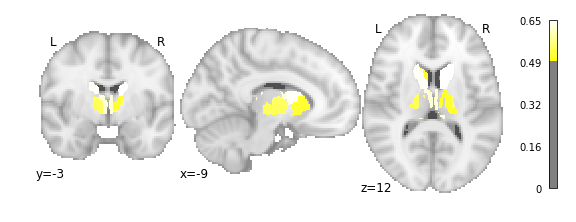

working on cluster 6
cluster size =  47


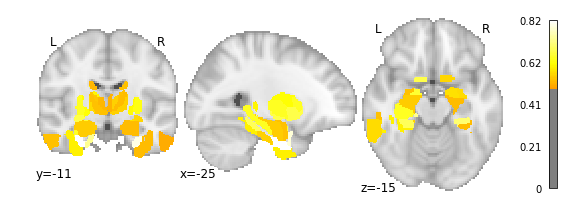

working on cluster 7
cluster size =  20


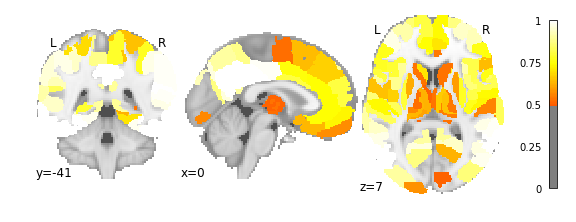

>>>>>>>> K = 10 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  51


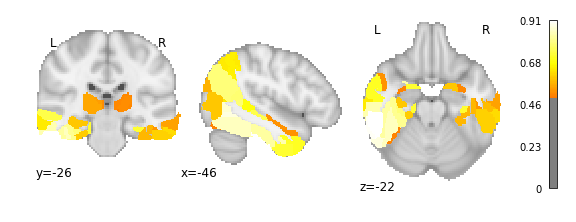

working on cluster 1
cluster size =  23


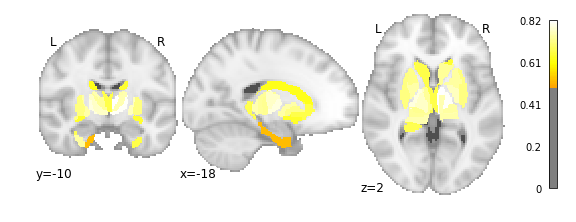

working on cluster 2
cluster size =  38


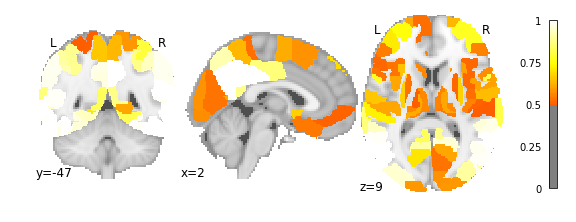

working on cluster 3
cluster size =  99
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


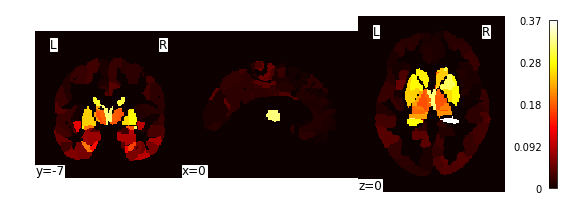

working on cluster 4
cluster size =  26


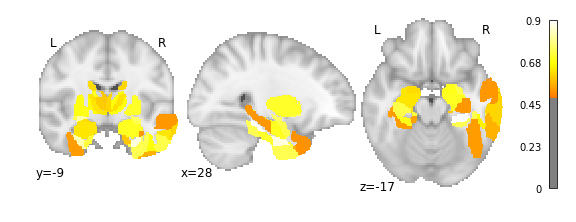

working on cluster 5
cluster size =  52


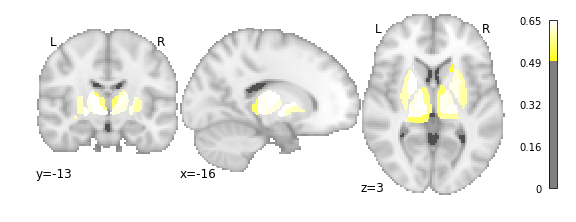

working on cluster 6
cluster size =  35


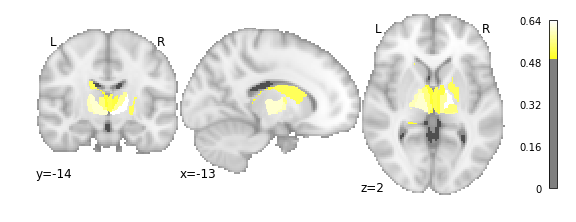

working on cluster 7
cluster size =  50


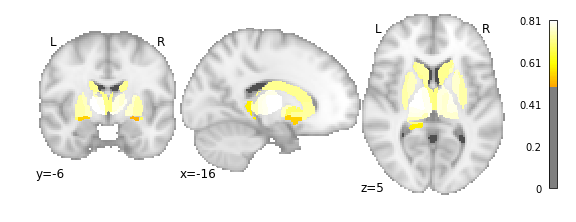

working on cluster 8
cluster size =  37


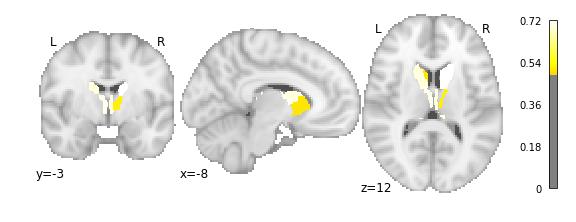

working on cluster 9
cluster size =  25


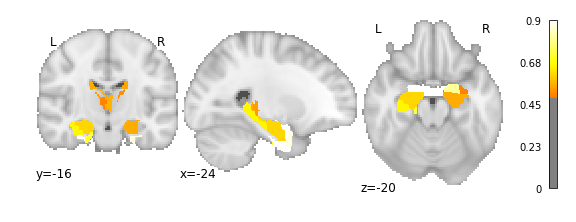

>>>>>>>> K = 12 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  42


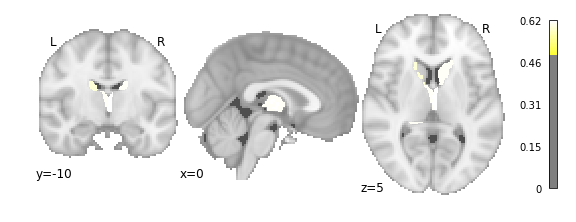

working on cluster 1
cluster size =  19


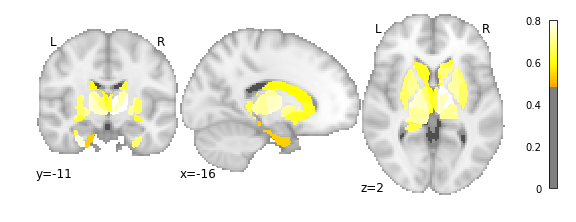

working on cluster 2
cluster size =  49


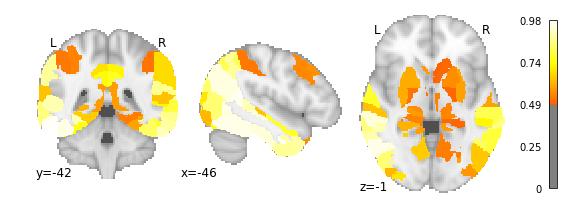

working on cluster 3
cluster size =  76
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


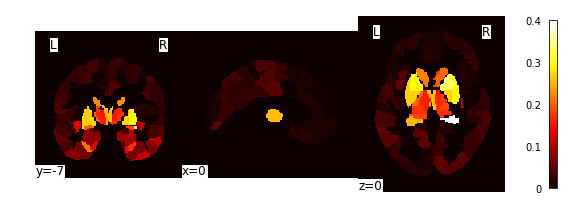

working on cluster 4
cluster size =  51


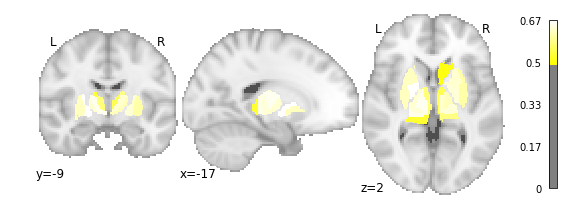

working on cluster 5
cluster size =  54


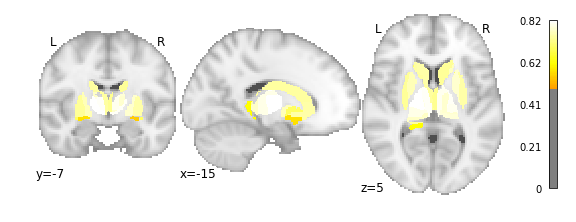

working on cluster 6
cluster size =  40


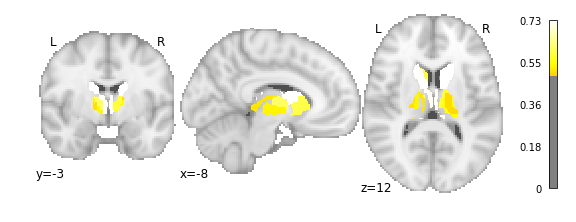

working on cluster 7
cluster size =  25


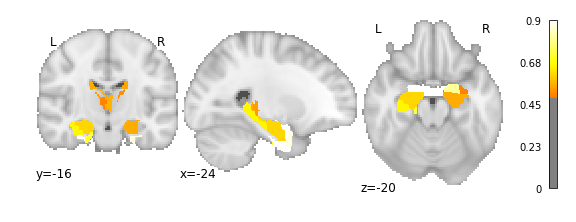

working on cluster 8
cluster size =  24


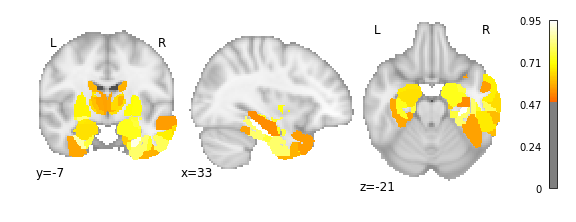

working on cluster 9
cluster size =  16


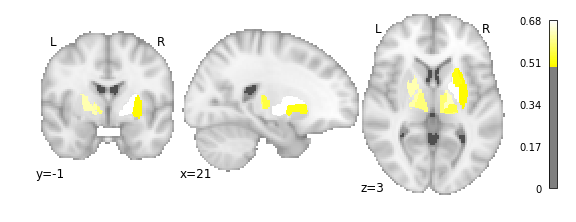

working on cluster 10
cluster size =  20


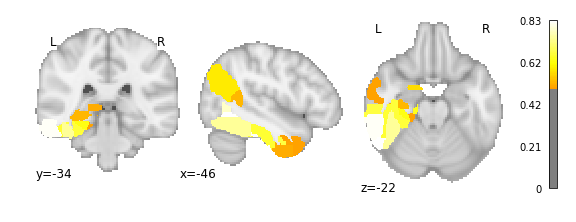

working on cluster 11
cluster size =  20


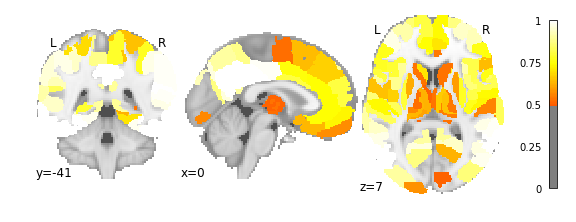

>>>>>>>> K = 14 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  54


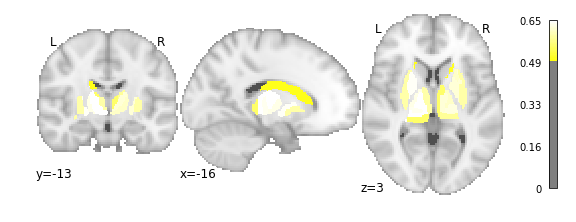

working on cluster 1
cluster size =  21


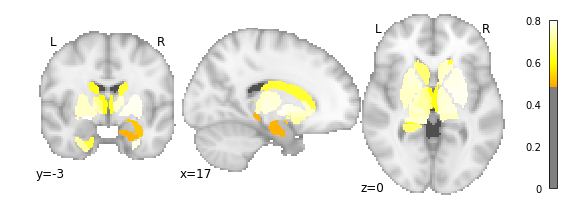

working on cluster 2
cluster size =  51
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


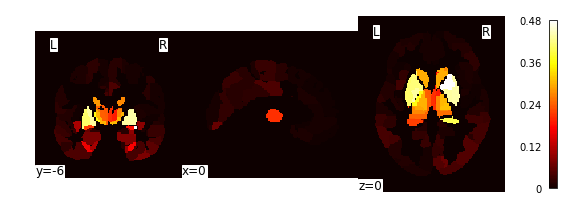

working on cluster 3
cluster size =  53


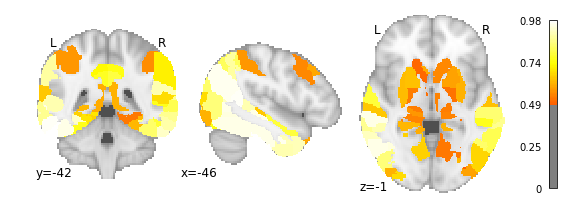

working on cluster 4
cluster size =  58


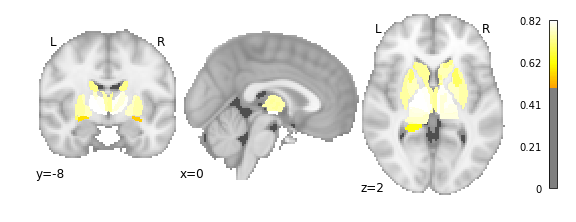

working on cluster 5
cluster size =  42


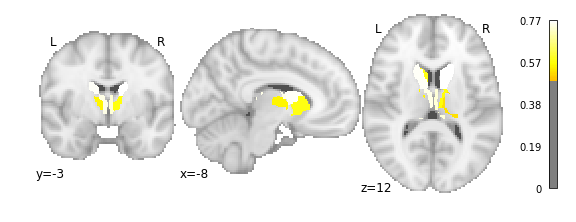

working on cluster 6
cluster size =  20


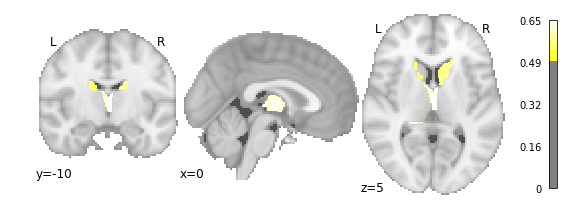

working on cluster 7
cluster size =  19


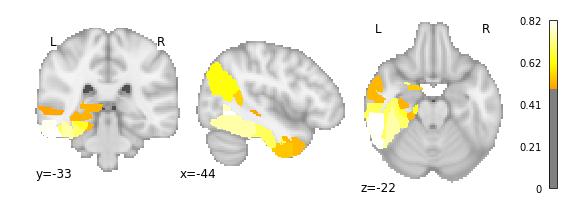

working on cluster 8
cluster size =  23


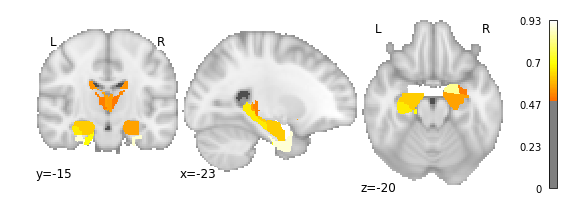

working on cluster 9
cluster size =  41
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


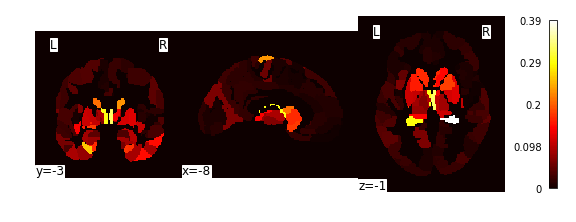

working on cluster 10
cluster size =  15


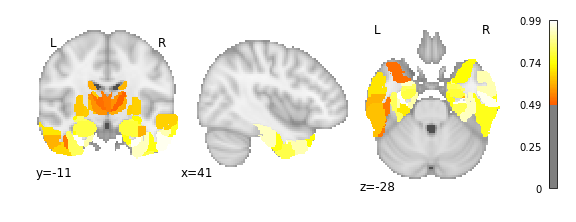

working on cluster 11
cluster size =  15


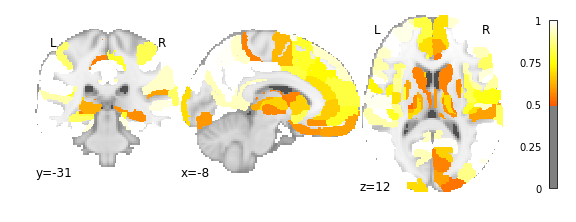

working on cluster 12
cluster size =  9


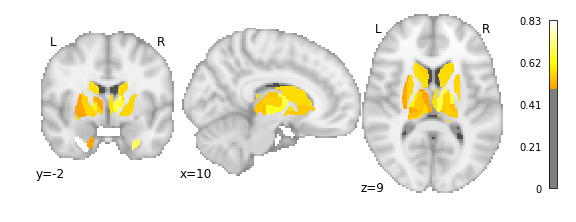

working on cluster 13
cluster size =  15


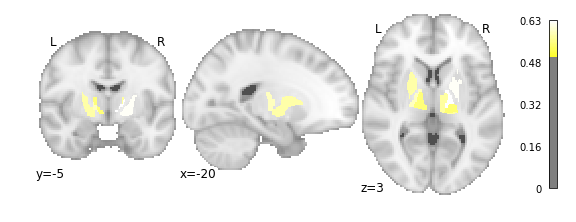

In [223]:
for k in [5, 6, 8, 10, 12, 14]:
    print('>>>>>>>> K = %s <<<<<<<<'%k)
    output = poormans_basc(input_data, k, 100, 100, True, None, True, 30, plotit=False)
    clust_imgs = visualize_clusters(input_data, rois, output['labels'], atl_pth, True, 0.5)

>>>>>>>> K = 5 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  115


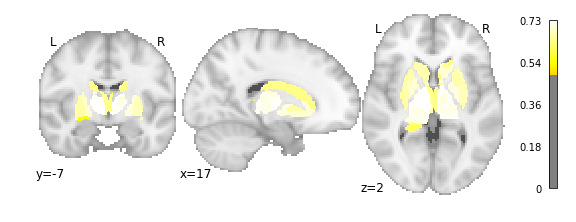

working on cluster 1
cluster size =  55


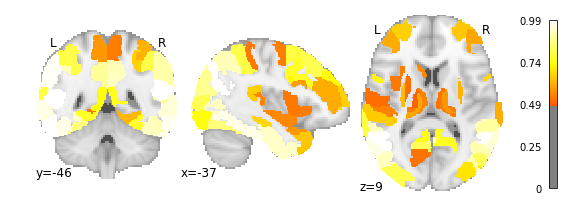

working on cluster 2
cluster size =  144
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


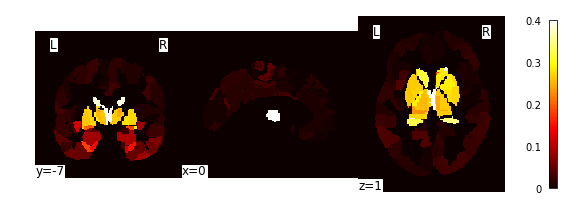

working on cluster 3
cluster size =  58


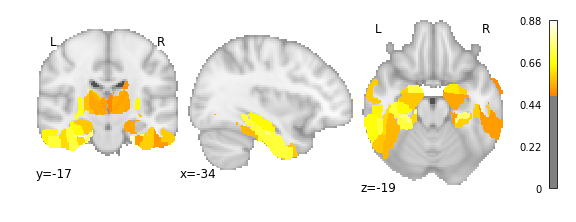

working on cluster 4
cluster size =  42


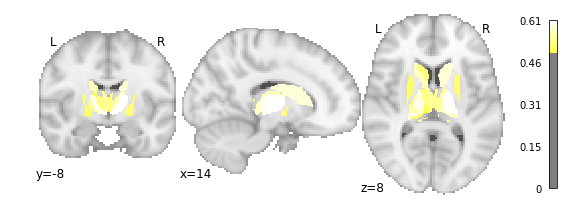

>>>>>>>> K = 6 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  55


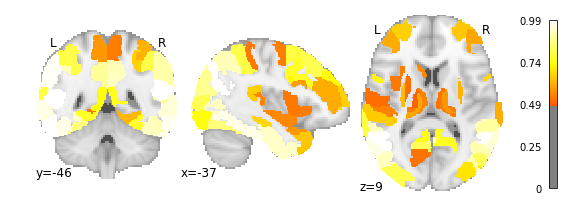

working on cluster 1
cluster size =  75


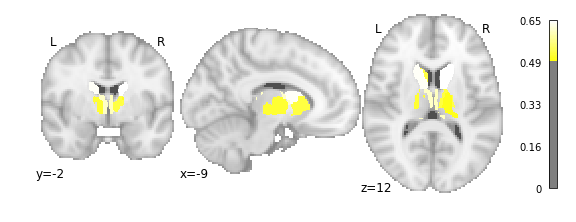

working on cluster 2
cluster size =  103


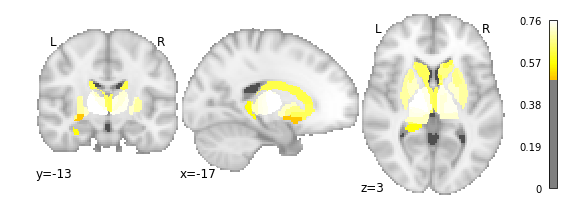

working on cluster 3
cluster size =  109
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


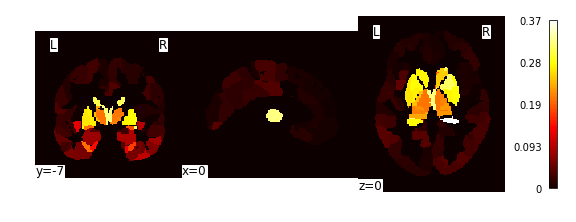

working on cluster 4
cluster size =  33


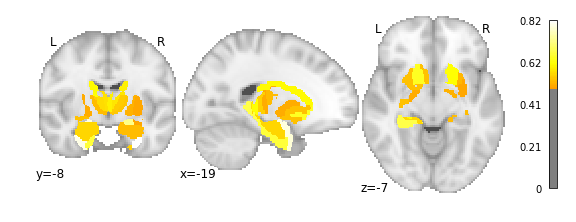

working on cluster 5
cluster size =  48


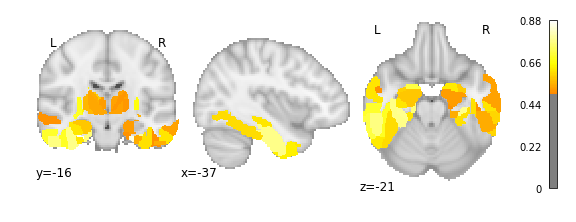

>>>>>>>> K = 8 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  53


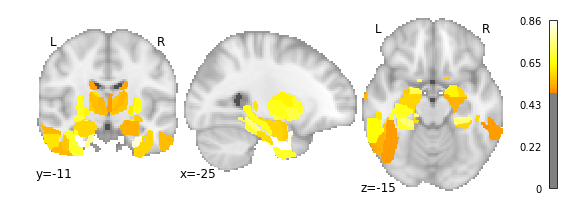

working on cluster 1
cluster size =  35


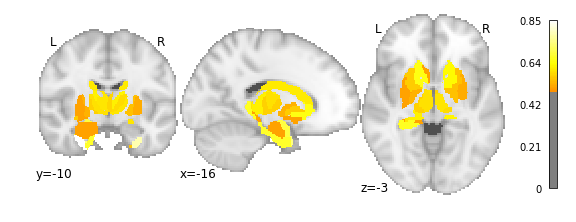

working on cluster 2
cluster size =  72


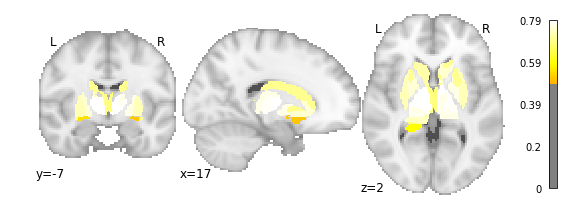

working on cluster 3
cluster size =  101
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


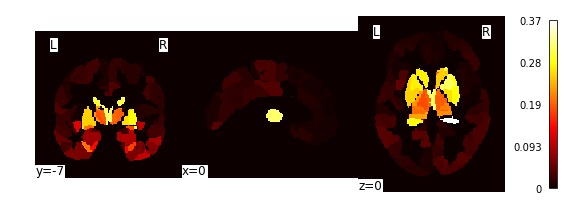

working on cluster 4
cluster size =  59


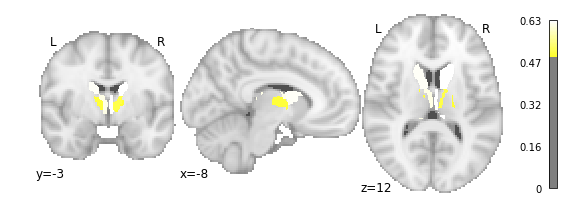

working on cluster 5
cluster size =  28


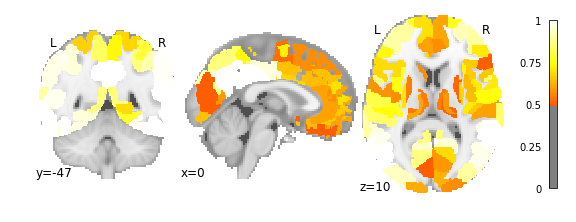

working on cluster 6
cluster size =  41


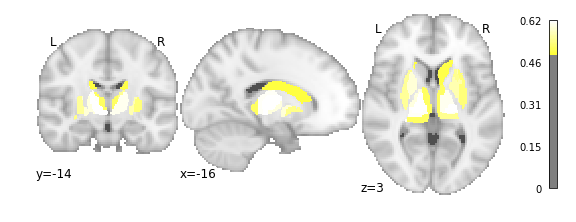

working on cluster 7
cluster size =  26


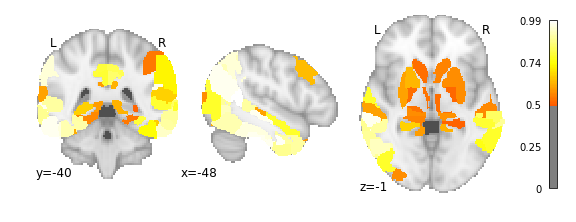

>>>>>>>> K = 10 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  43


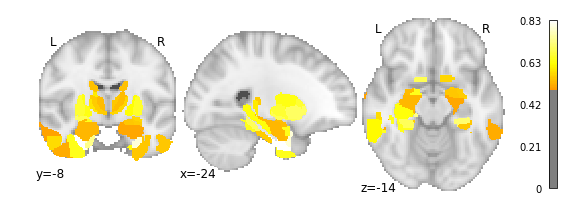

working on cluster 1
cluster size =  96
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


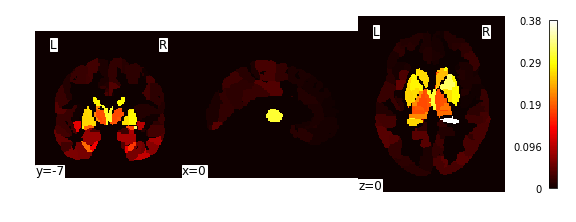

working on cluster 2
cluster size =  43


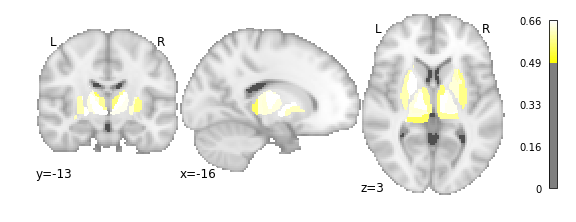

working on cluster 3
cluster size =  46


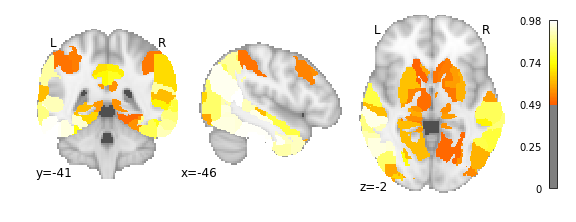

working on cluster 4
cluster size =  18


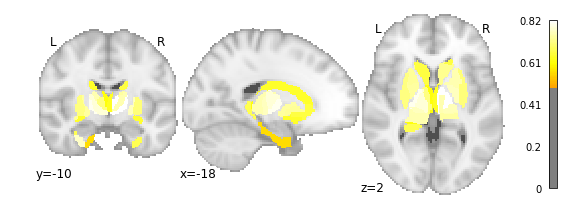

working on cluster 5
cluster size =  62


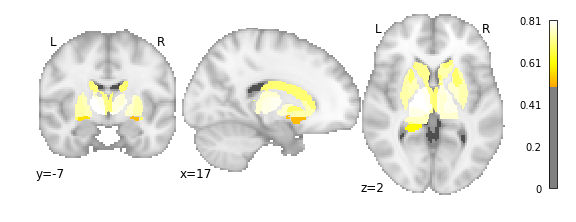

working on cluster 6
cluster size =  40


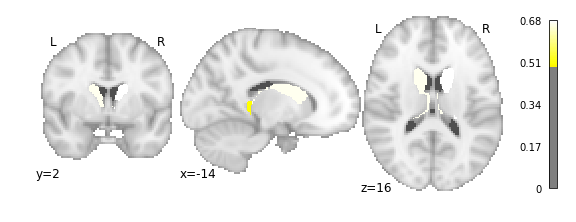

working on cluster 7
cluster size =  25


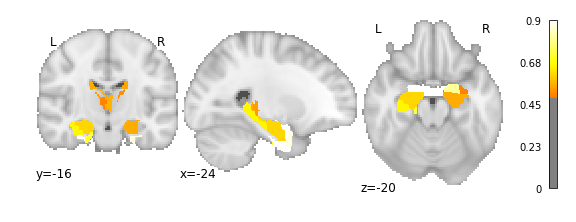

working on cluster 8
cluster size =  20


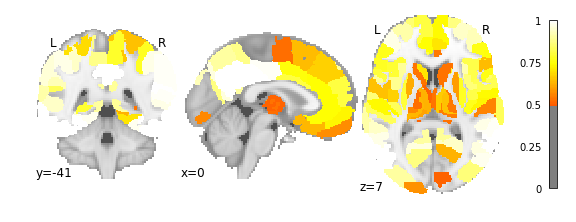

working on cluster 9
cluster size =  28


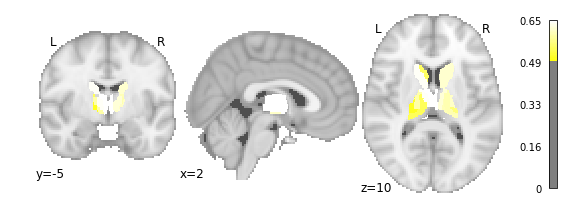

>>>>>>>> K = 12 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  39
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


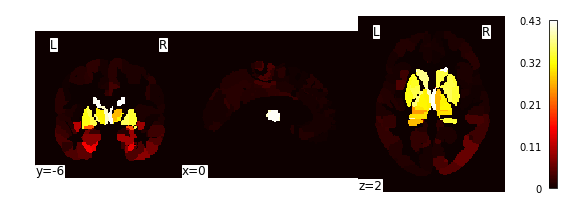

working on cluster 1
cluster size =  14


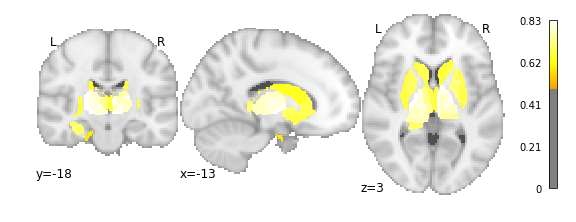

working on cluster 2
cluster size =  54


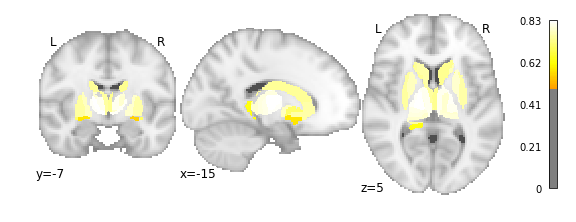

working on cluster 3
cluster size =  22


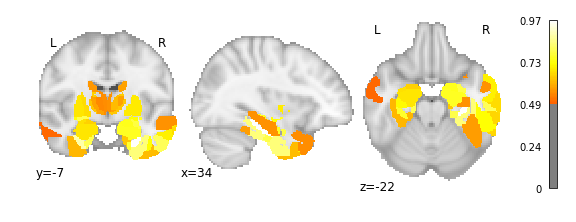

working on cluster 4
cluster size =  44


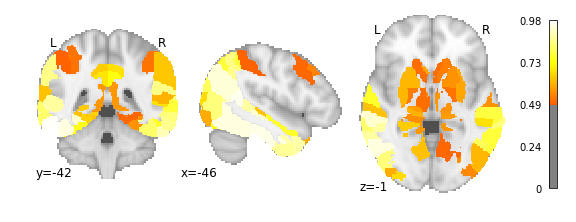

working on cluster 5
cluster size =  44


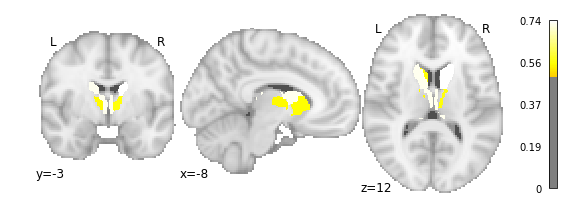

working on cluster 6
cluster size =  68
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


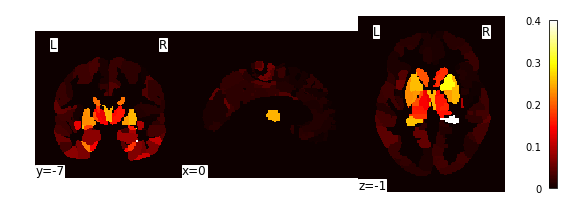

working on cluster 7
cluster size =  35


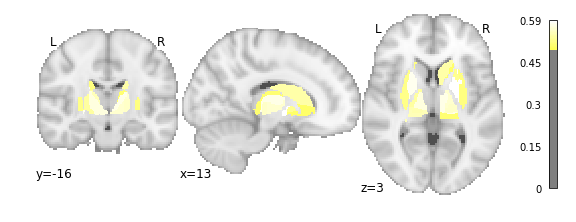

working on cluster 8
cluster size =  24


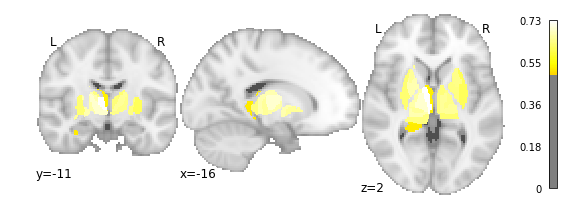

working on cluster 9
cluster size =  22


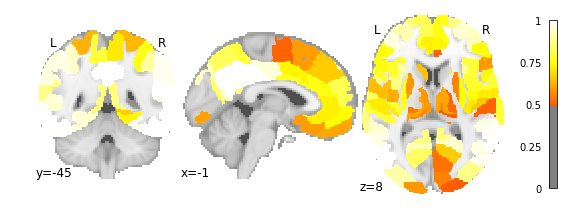

working on cluster 10
cluster size =  20


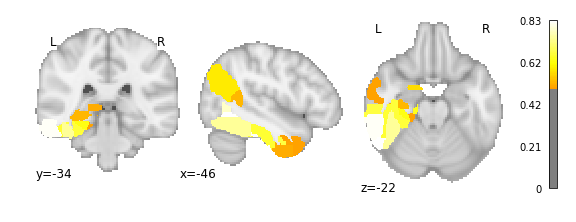

working on cluster 11
cluster size =  22


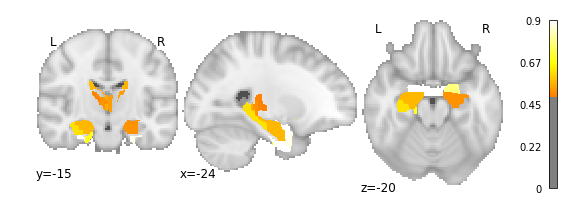

>>>>>>>> K = 14 <<<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
working on cluster 0
cluster size =  36


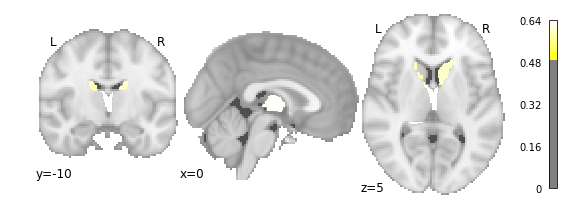

working on cluster 1
cluster size =  56


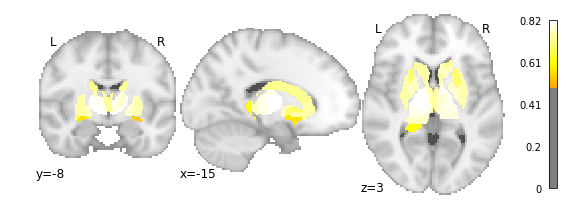

working on cluster 2
cluster size =  16


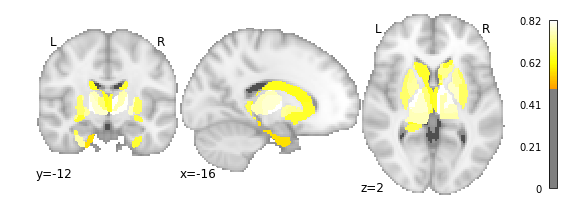

working on cluster 3
cluster size =  15


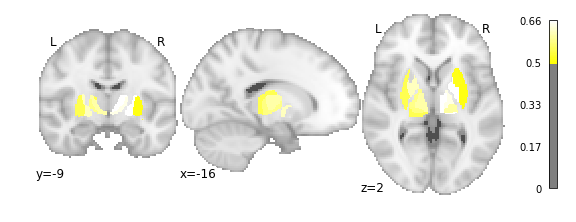

working on cluster 4
cluster size =  24


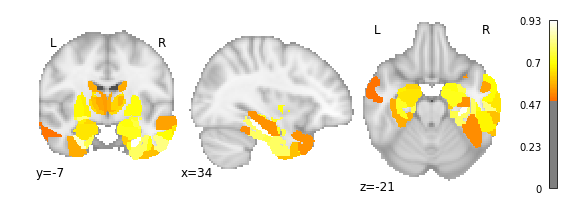

working on cluster 5
cluster size =  49


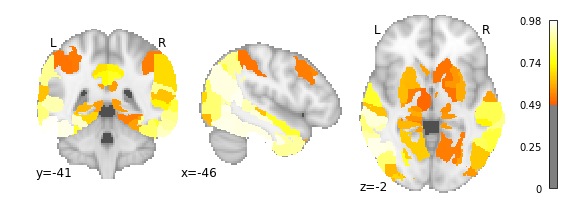

working on cluster 6
cluster size =  32


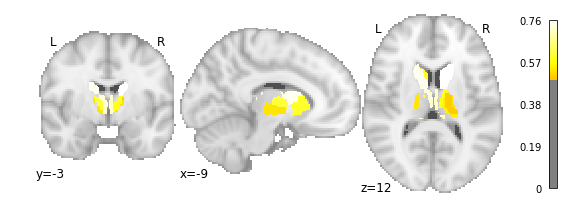

working on cluster 7
cluster size =  25


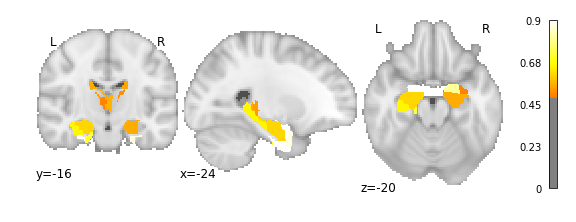

working on cluster 8
cluster size =  28


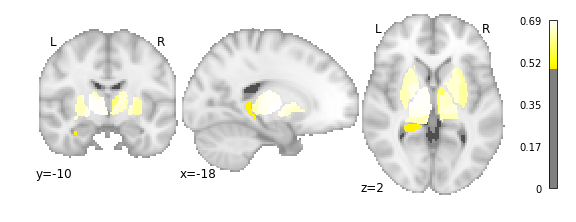

working on cluster 9
cluster size =  63
no rois above specified threshold. loosening threshold
no rois above loosened threshold. no threshold applied


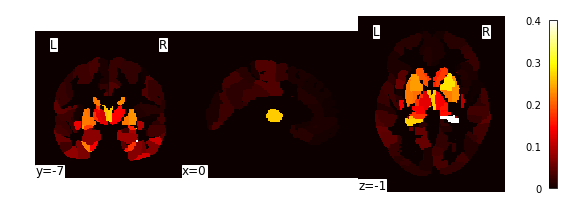

working on cluster 10
cluster size =  17


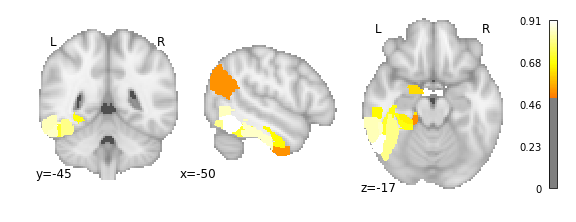

working on cluster 11
cluster size =  15


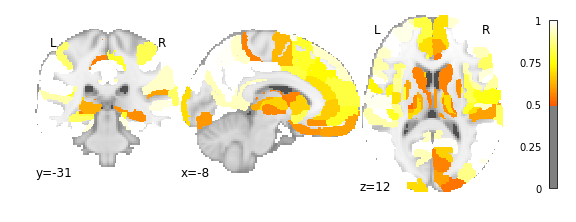

working on cluster 12
cluster size =  18


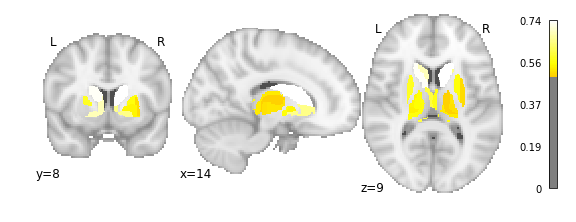

working on cluster 13
cluster size =  15


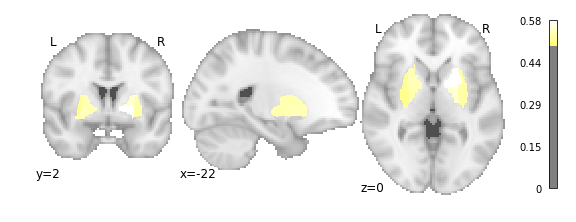

In [245]:
for k in [5, 6, 8, 10, 12, 14]:
    print('>>>>>>>> K = %s <<<<<<<<'%k)
    output = poormans_basc(input_data, k, 100, 100, True, None, True, 30, plotit=False)
    jnk = silhouette_samples(output['stability'],output['labels'])
    good_fits = [x for x in range(len(jnk)) if jnk[x]>0]
    tmp_mtx = input_data.loc[input_data.index[good_fits]]
    newlabs = output['labels'][good_fits]
    clust_imgs = visualize_clusters(tmp_mtx, rois, newlabs, atl_pth, True, 0.5)

In [224]:
from sklearn.metrics import silhouette_samples

In [228]:
jnk = silhouette_samples(output['stability'],output['labels'])

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


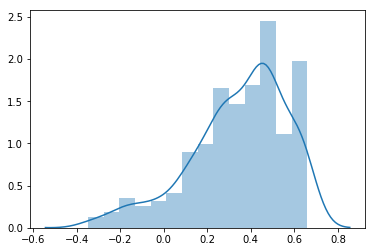

In [231]:
sns.distplot(jnk)